## Loading of Steinmetz data

includes some visualizations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from scipy.optimize import minimize
from scipy.io import loadmat
import itertools as it
from matplotlib_venn import venn2

In [2]:
from fetch_data import fetch_data_if_not_exist

files = [f"steinmetz_part{i}.npz" for i in range(3)]
urls = [
    "https://osf.io/agvxh/download",
    "https://osf.io/uv3mw/download",
    "https://osf.io/ehmw2/download",
]

for file_name, url in zip(files, urls):
    fetch_data_if_not_exist(file_name, url)

In [3]:
# @title Data loading
alldata = np.array([])
for file in files:
    data = np.load(file, allow_pickle=True)["dat"] # np.load(file).files = ["dat"]
    alldata = np.hstack((alldata, data))


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned). 

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['ccf']`: Allen Institute brain atlas coordinates for each neuron. 
* `dat['ccf_axes']`: axes names for the Allen CCF. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_time']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: turning speed of the wheel that the mice uses to make a response, sampled at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position.
* `dat['face']`: average face motion energy from a video camera. 
* `dat['licks']`: lick detections, 0 or 1.   
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 
* `dat['prev_reward']`: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time. 
* `dat['reaction_time']`: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above `5` ticks/10ms bin. Second column: direction of the wheel movement (`0` = no move detected).  


The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406

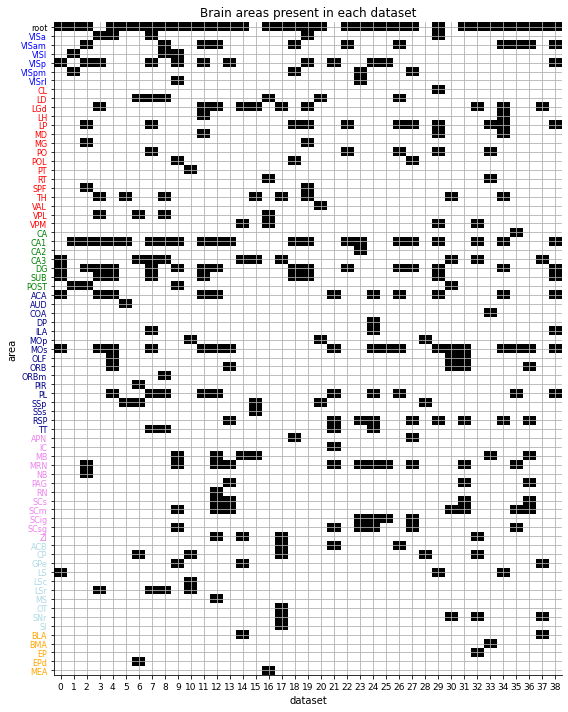

In [4]:
# Make a plot of which brain areas are present in each dataset
# note that region 4 ("other ctx" are neurons that were not able to be classified)
# region 4 does not correspond to brain_group 4, which are all cortical neurons outside of visual cortex
from constants import regions, region_colors, brain_groups

# Assign each area an index
area_to_index = dict(root=0)
for i, area in enumerate([area for group in brain_groups for area in group]):
    area_to_index[area] = i + 1

# Figure out which areas are in each dataset
areas_by_dataset = np.zeros((len(area_to_index), len(alldata)), dtype=bool)
for j, d in enumerate(alldata):
    for area in np.unique(d['brain_area']):
        i = area_to_index[area]
        areas_by_dataset[i, j] = True

# Show the binary matrix
plt.figure(figsize=(8, 10))
plt.imshow(areas_by_dataset, cmap="Greys", aspect="auto", interpolation="none")

# Label the axes
plt.xlabel("dataset")
plt.ylabel("area")

# Add tick labels
yticklabels = ["root"]
for group in brain_groups:
  yticklabels.extend(group)
plt.yticks(np.arange(len(area_to_index)), yticklabels, fontsize=8)
plt.xticks(np.arange(len(alldata)), fontsize=9)

# Color the tick labels by region
ytickobjs = plt.gca().get_yticklabels()
ytickobjs[0].set_color("black")
counter = 1
for group, color in zip(brain_groups, region_colors):
  for area in group:
    ytickobjs[counter].set_color(color)
    counter += 1

plt.title("Brain areas present in each dataset")
plt.grid(True)
plt.show()

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


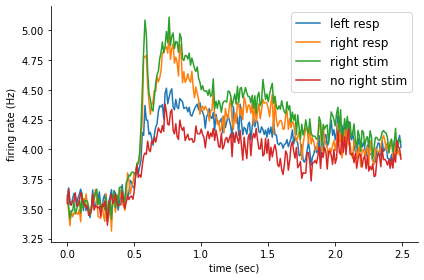

In [5]:
# @title Basic plots of population average

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldata[11]
print(dat.keys())

dt = dat['bin_size']  # binning at 10 ms
NT = dat['spks'].shape[-1]

response = dat['response']  # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right']  # 0 - low - high
vis_left = dat['contrast_left']  # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response >= 0].mean(axis=(0, 1)))  # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, response < 0].mean(axis=(0, 1)))  # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right > 0].mean(axis=(0, 1)))  # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:, vis_right == 0].mean(axis=(0, 1)))  # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
plt.xlabel('time (sec)')
plt.ylabel('firing rate (Hz)')

plt.show()

In [6]:
nareas = 4  # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area'])  # number of neurons
barea = nareas * np.ones(NN, )  # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j  # assign a number to each region

AttributeError: 'AxesSubplot' object has no property 'box_aspect'

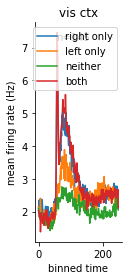

In [7]:
# @title plots by brain region and visual conditions

for j in range(nareas):
  ax = plt.subplot(1, nareas, j+1)

  ax.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0, 1)))
  ax.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right == 0)].mean(axis=(0, 1)))
  ax.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0, 1)))
  ax.plot(1/dt * dat['spks'][barea==j][:, np.logical_and(vis_left > 0, vis_right > 0)].mean(axis=(0, 1)))
  ax.text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax.transAxes)
  if j == 0:
    plt.legend(['right only', 'left only', 'neither', 'both'])
  ax.set(box_aspect=1.2, xlabel='binned time', ylabel='mean firing rate (Hz)', title=regions[j])

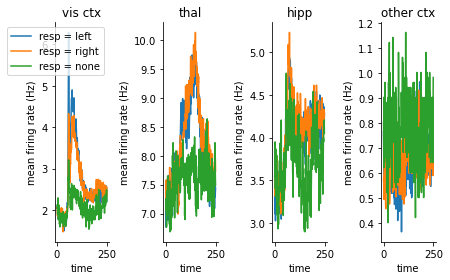

In [8]:
# @title plots by brain region and response type
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)
  plt.title(regions[j])
  if np.sum(barea == j) == 0:
    continue
  plt.plot(1/dt * dat['spks'][barea == j][:, response < 0].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea == j][:, response > 0].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks'][barea == j][:, response == 0].mean(axis=(0, 1)))

  if j == 0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'])
  ax.set(xlabel='time', ylabel='mean firing rate (Hz)')
plt.show()

In [ ]:
# @title top PC directions from stimulus + response period, with projections of the entire duration

droll = np.reshape(dat['spks'][:, :, 51:130], (NN, -1))  # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components=5).fit(droll.T)
W: np.ndarray = model.components_ # type: ignore
pc_10ms = W @ np.reshape(dat['spks'], (NN, -1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

In [9]:
# @title The top PCs capture most variance across the brain. What do they care about?
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
  ax = plt.subplot(2, len(pc_10ms) + 1, j + 1)
  pc1 = pc_10ms[j]

  plt.plot(pc1[np.logical_and(vis_left == 0, vis_right > 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left > 0, vis_right == 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left == 0, vis_right == 0), :].mean(axis=0))
  plt.plot(pc1[np.logical_and(vis_left > 0, vis_right > 0), :].mean(axis=0))

  if j == 0:
    plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
  ax.set(xlabel = 'binned time', ylabel='mean firing rate (Hz)')
  plt.title('PC %d'%j)

  ax = plt.subplot(2, len(pc_10ms) + 1, len(pc_10ms) + 1 + j + 1)

  plt.plot(pc1[response > 0, :].mean(axis=0))
  plt.plot(pc1[response < 0, :].mean(axis=0))
  plt.plot(pc1[response == 0, :].mean(axis=0))

  if j == 0:
    plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)')
  plt.title('PC %d'%j)
plt.show()

NameError: name 'pc_10ms' is not defined

<Figure size 1440x432 with 0 Axes>

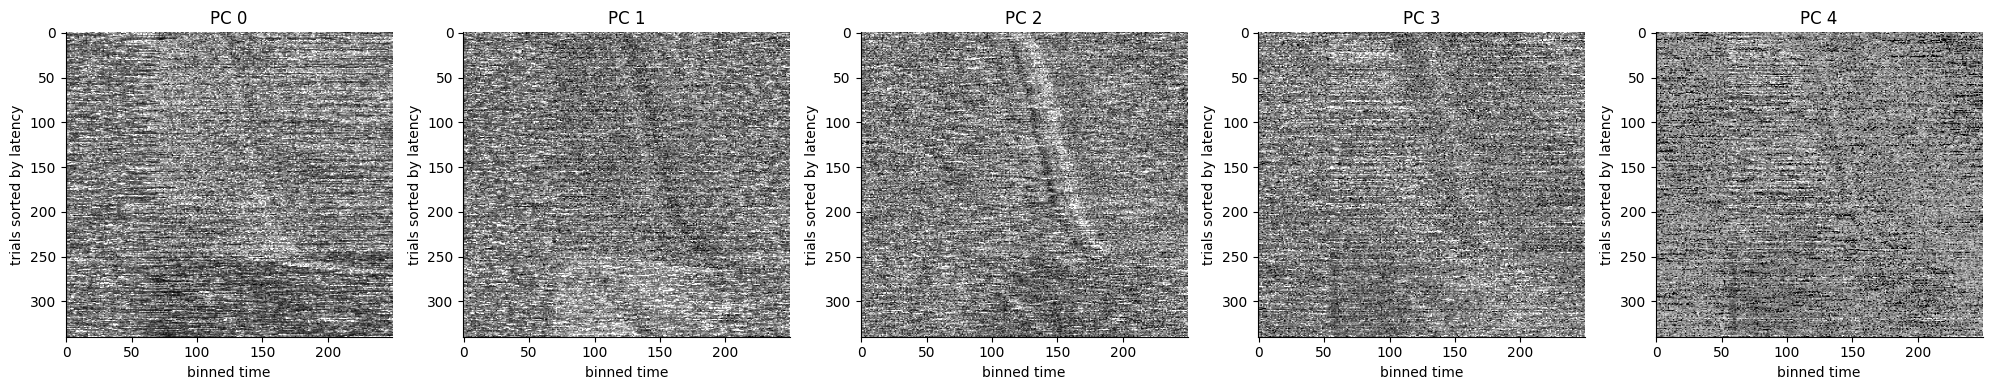

In [ ]:
# @title now sort all trials by response latency and see if the PCs care about that.
isort = np.argsort(dat['response_time'].flatten())

for j in range(len(pc_10ms)):
  ax = plt.subplot(1, len(pc_10ms) + 1, j + 1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin=-2, cmap='gray')
  ax.set(xlabel='binned time', ylabel='trials sorted by latency')
  plt.title('PC %d'%j)
plt.show()

In [10]:
# @title correct vs incorrect trials
# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response) == np.sign(vis_left - vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10)

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1, len(pc_10ms) + 1, j + 1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin=-2, cmap='gray')
  ax.set(xlabel='binned time')
  if j == 0:
    ax.set(ylabel='trials sorted by latency')
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')
plt.show()

NameError: name 'pc_10ms' is not defined

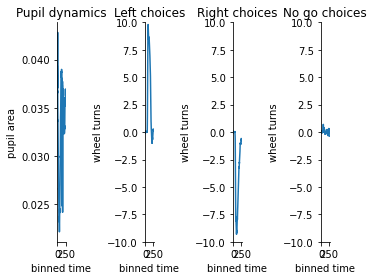

In [11]:
# plot the behavioral data (pupil area is noisy because it's very small)

ax = plt.subplot(1, 5, 1)
plt.plot(dat['pupil'][0, :].mean(0));
ax.set(ylabel='pupil area', xlabel='binned time', title='Pupil dynamics')

yl = [-10, 10]
ax = plt.subplot(1, 5, 2)
plt.plot(dat['wheel'][0, response > 0].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='Left choices')

ax = plt.subplot(1, 5, 3)
plt.plot(dat['wheel'][0, response<0].mean(0))
ax.set(ylim=yl)
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='Right choices')

ax = plt.subplot(1, 5, 4)
plt.plot(dat['wheel'][0, response==0].mean(0))
ax.set(ylim=yl, ylabel='wheel turns', xlabel='binned time', title='No go choices')
plt.show()

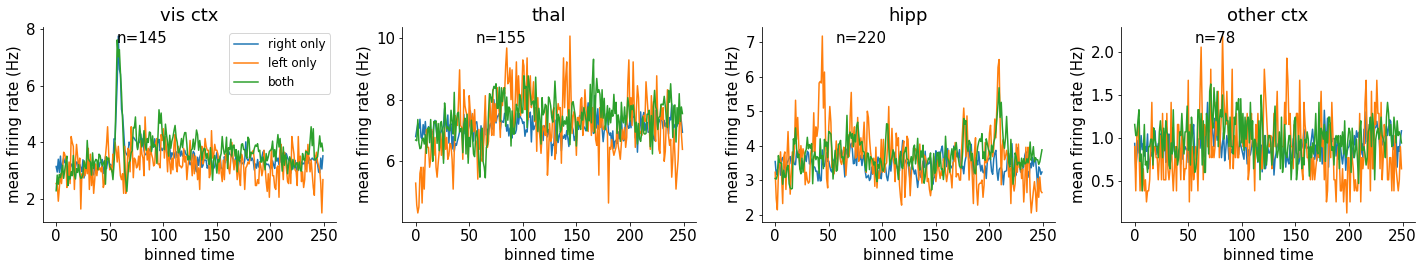

In [ ]:
# plots by brain region and visual conditions for PASSIVE trials
vis_left_p = dat['contrast_left_passive']
vis_right_p = dat['contrast_right_passive']
for j in range(nareas):
  ax = plt.subplot(1, nareas, j + 1)
  plt.title(regions[j])

  plt.plot(1/dt * dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p == 0, vis_right_p > 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p > 0, vis_right_p == 0)].mean(axis=(0, 1)))
  #plt.plot(1/dt *  dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p == 0, vis_right_p == 0)].mean(axis=(0, 1)))
  plt.plot(1/dt * dat['spks_passive'][barea == j][:, np.logical_and(vis_left_p > 0, vis_right_p > 0)].mean(axis=(0, 1)))
  plt.text(.25, .92, 'n=%d'%np.sum(barea == j), transform=ax.transAxes)

  if j == 0:
    plt.legend(['right only', 'left only', 'both'], fontsize=12)
  ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)')
plt.show()

neuron: (734, 214, 250)
reward_index: (74,)
reward_index ex.: [18 24 29 30 36]
vision_index: (147,)
action_index: (184,)
choice_index: (111,)
index_all: (4,)
r_v_and: (15,)
reward_ratio: [0.2027027  0.17567568 0.16216216 0.10204082 0.07065217 0.10810811]


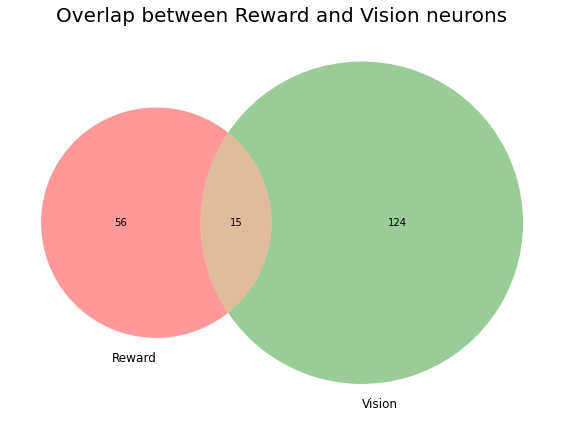

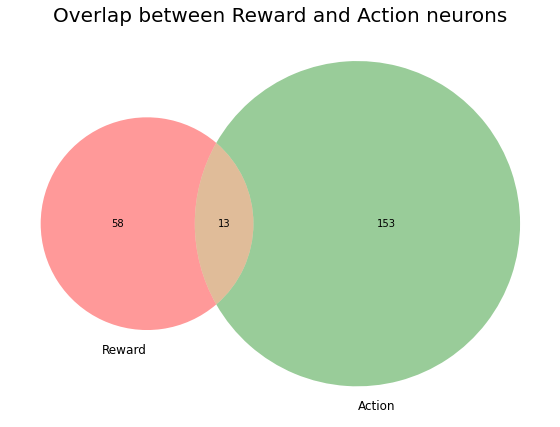

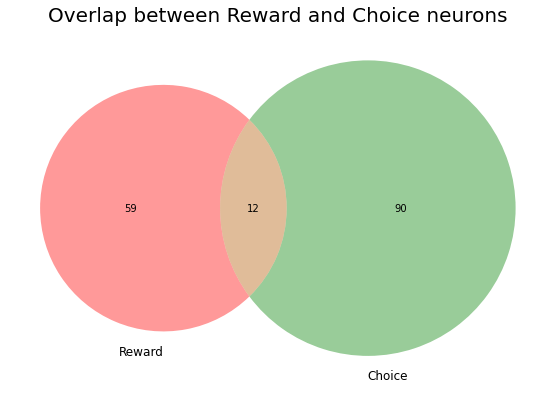

reward_area_all: ['MOs' 'LS' 'DG' 'root' 'CA3' 'SUB' 'VISp' 'ACA']
reward_ratio: (6, 9)
neuron: (1070, 251, 250)
reward_index: (107,)
reward_index ex.: [ 0  2 33 37 48]
vision_index: (214,)
action_index: (268,)
choice_index: (161,)
index_all: (4,)
r_v_and: (15,)
reward_ratio: [0.14018692 0.27102804 0.14953271 0.07009346 0.10820896 0.09937888]


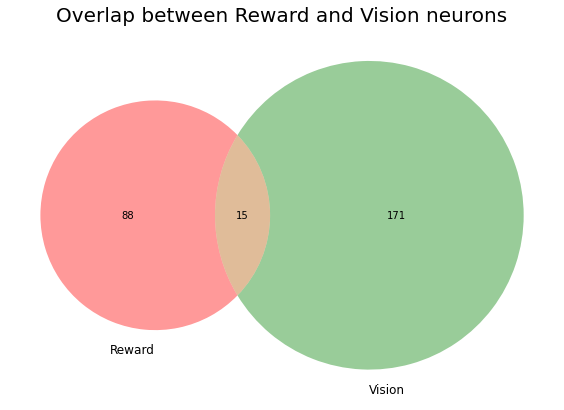

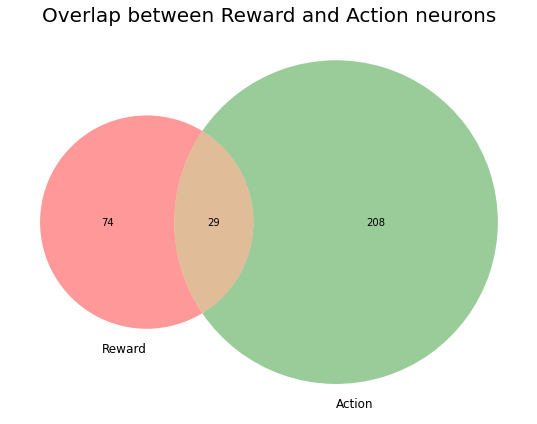

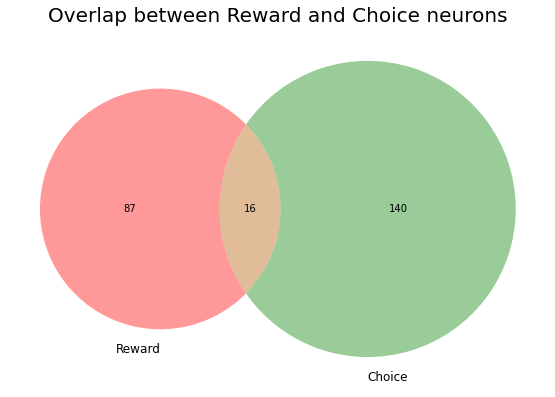

reward_area_all: ['root' 'CA1' 'VISpm' 'POST' 'VISl']
reward_ratio: (6, 6)
neuron: (619, 228, 250)
reward_index: (62,)
reward_index ex.: [30 35 54 66 68]
vision_index: (124,)
action_index: (155,)
choice_index: (93,)
index_all: (4,)
r_v_and: (10,)
reward_ratio: [0.16129032 0.17741935 0.16129032 0.08064516 0.07096774 0.10752688]


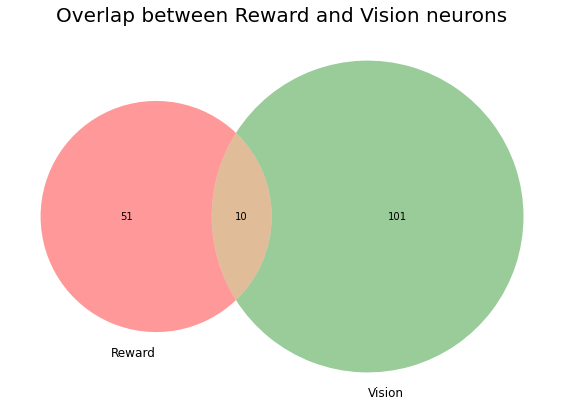

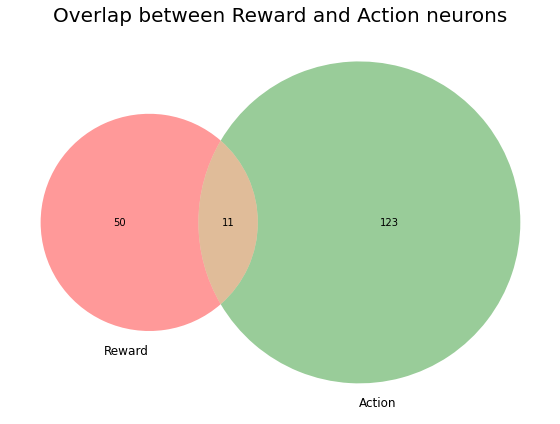

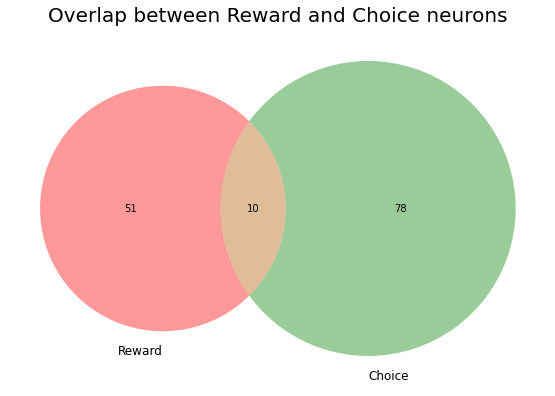

reward_area_all: ['DG' 'CA1' 'NB' 'SPF' 'VISp' 'MRN' 'POST' 'MG' 'VISam']
reward_ratio: (6, 10)
neuron: (1769, 249, 250)
reward_index: (177,)
reward_index ex.: [ 2  7 11 13 15]
vision_index: (354,)
action_index: (443,)
choice_index: (266,)
index_all: (4,)
r_v_and: (27,)
reward_ratio: [0.15254237 0.24293785 0.20903955 0.07627119 0.09706546 0.13909774]


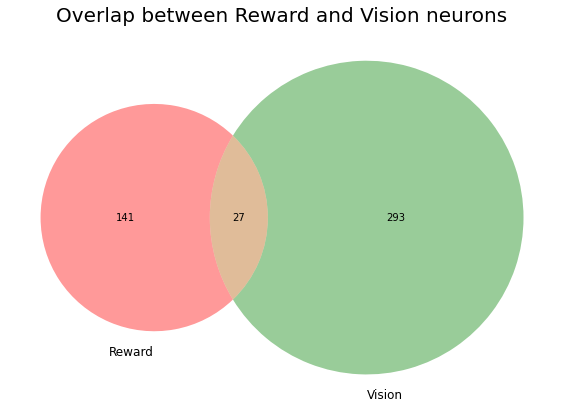

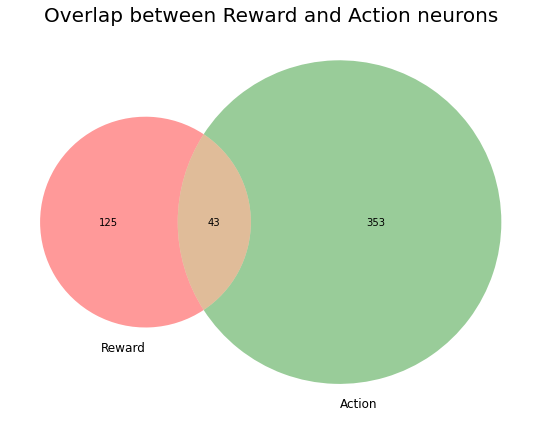

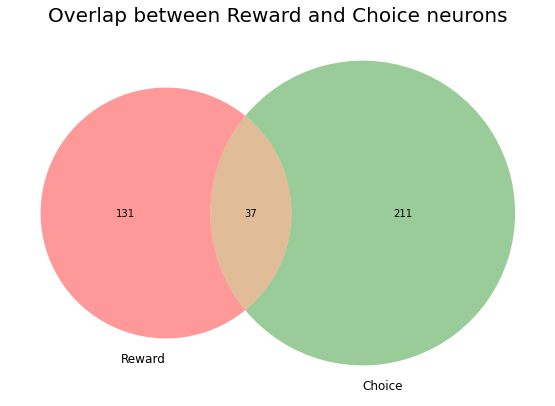

reward_area_all: ['MOs' 'DG' 'TH' 'CA1' 'VPL' 'SUB' 'VISp' 'LSr' 'VISa' 'ACA' 'LGd']
reward_ratio: (6, 12)
neuron: (1077, 254, 250)
reward_index: (108,)
reward_index ex.: [ 9 16 19 21 47]
vision_index: (216,)
action_index: (270,)
choice_index: (162,)
index_all: (4,)
r_v_and: (18,)
reward_ratio: [0.16666667 0.19444444 0.12037037 0.08333333 0.07777778 0.08024691]


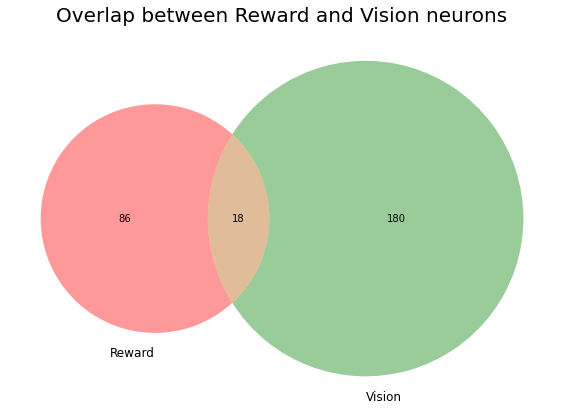

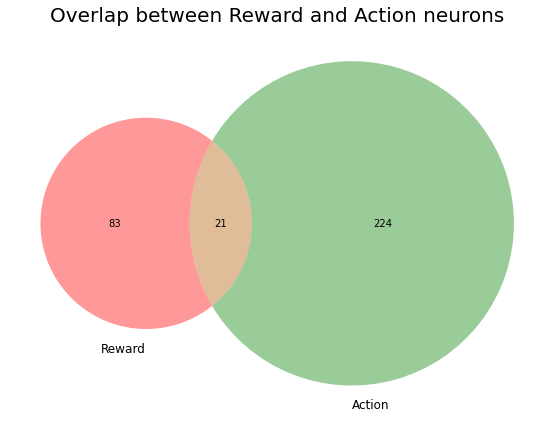

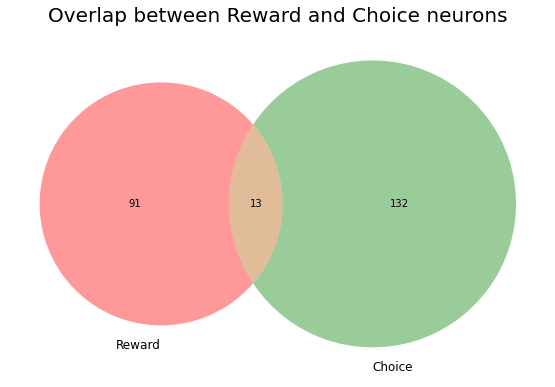

reward_area_all: ['MOs' 'DG' 'CA1' 'root' 'ORB' 'OLF' 'SUB' 'PL' 'VISa' 'ACA']
reward_ratio: (6, 11)
neuron: (1169, 290, 250)
reward_index: (117,)
reward_index ex.: [20 21 33 60 65]
vision_index: (234,)
action_index: (293,)
choice_index: (176,)
index_all: (4,)
r_v_and: (19,)
reward_ratio: [0.16239316 0.1965812  0.1025641  0.08119658 0.07849829 0.06818182]


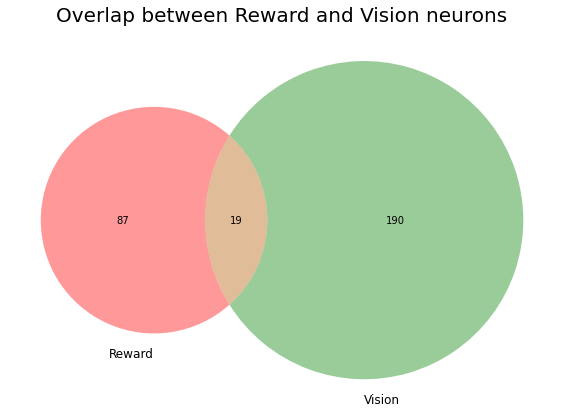

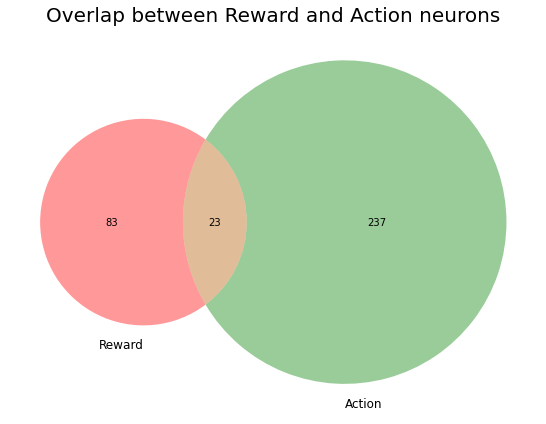

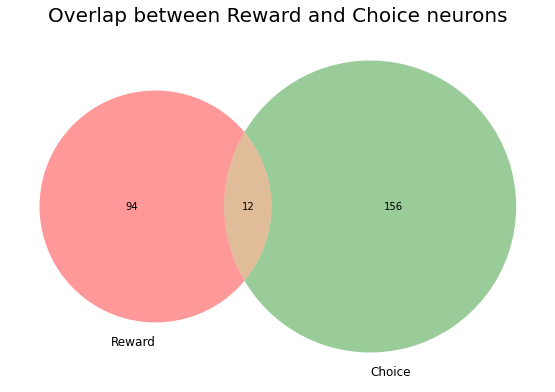

reward_area_all: ['AUD' 'SSp' 'root' 'CA1' 'TH']
reward_ratio: (6, 6)
neuron: (584, 252, 250)
reward_index: (59,)
reward_index ex.: [ 8 22 33 44 50]
vision_index: (117,)
action_index: (146,)
choice_index: (88,)
index_all: (4,)
r_v_and: (9,)
reward_ratio: [0.15254237 0.18644068 0.13559322 0.07692308 0.07534247 0.09090909]


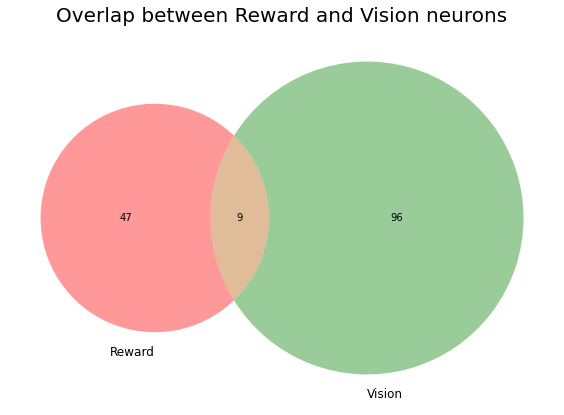

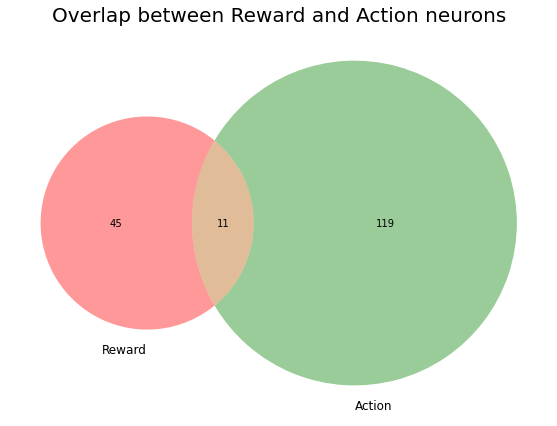

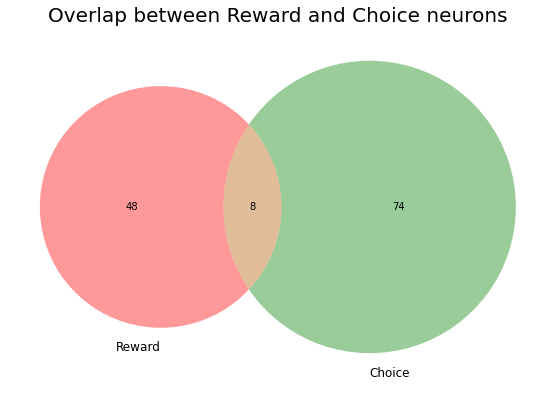

reward_area_all: ['SSp' 'root' 'CP' 'EPd' 'VPL' 'CA3' 'LD' 'PIR']
reward_ratio: (6, 9)
neuron: (1156, 250, 250)
reward_index: (116,)
reward_index ex.: [ 2 12 26 33 35]
vision_index: (232,)
action_index: (289,)
choice_index: (174,)
index_all: (4,)
r_v_and: (16,)
reward_ratio: [0.13793103 0.21551724 0.14655172 0.06896552 0.08650519 0.09770115]


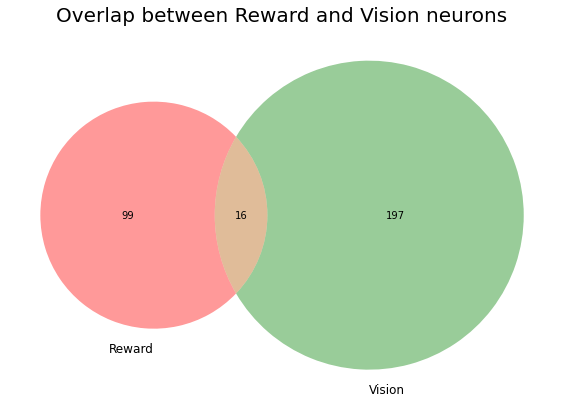

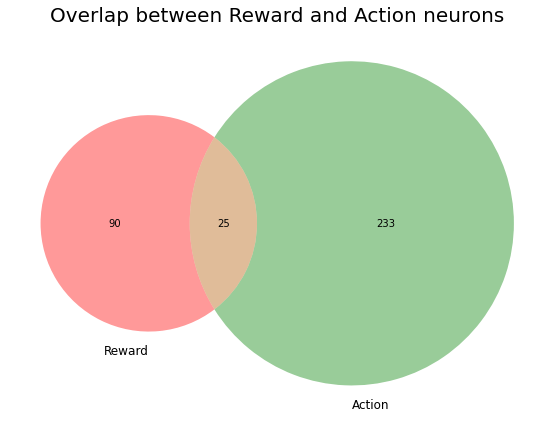

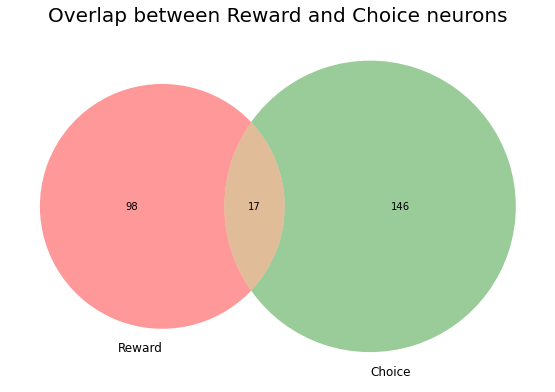

reward_area_all: ['MOs' 'TT' 'PO' 'ILA' 'CA1' 'DG' 'CA3' 'SUB' 'LD' 'VISp' 'PL' 'VISa' 'LP']
reward_ratio: (6, 14)
neuron: (788, 372, 250)
reward_index: (79,)
reward_index ex.: [ 4  8 18 56 62]
vision_index: (158,)
action_index: (197,)
choice_index: (119,)
index_all: (4,)
r_v_and: (5,)
reward_ratio: [0.06329114 0.20253165 0.16455696 0.03164557 0.08121827 0.1092437 ]


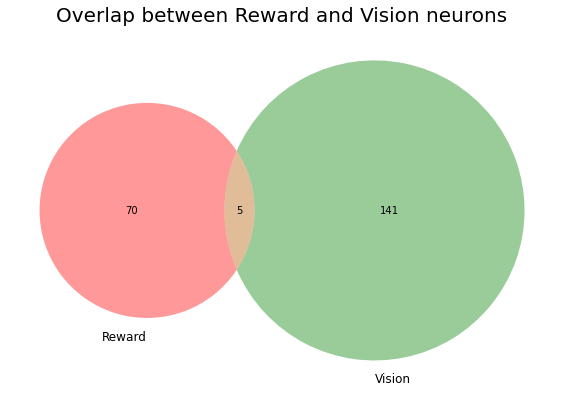

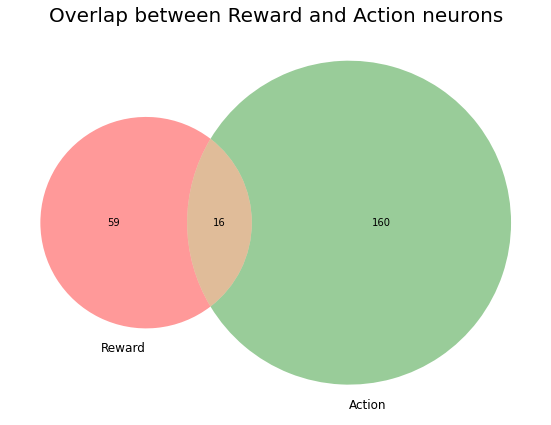

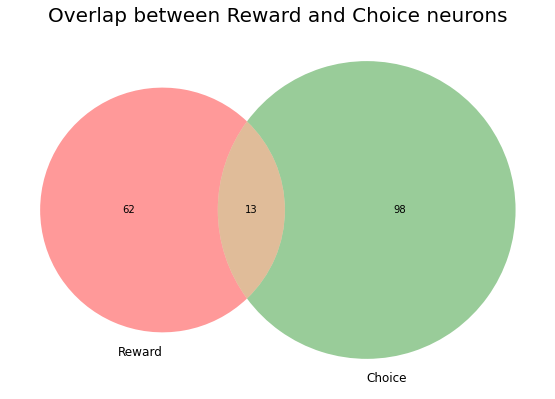

reward_area_all: ['TT' 'root' 'ORBm' 'CA1' 'TH' 'VPL' 'CA3' 'LD' 'LSr' 'PL' 'VISl' 'VISam']
reward_ratio: (6, 13)
neuron: (1172, 447, 250)
reward_index: (118,)
reward_index ex.: [10 15 30 43 47]
vision_index: (235,)
action_index: (293,)
choice_index: (176,)
index_all: (4,)
r_v_and: (15,)
reward_ratio: [0.12711864 0.16101695 0.11016949 0.06382979 0.06484642 0.07386364]


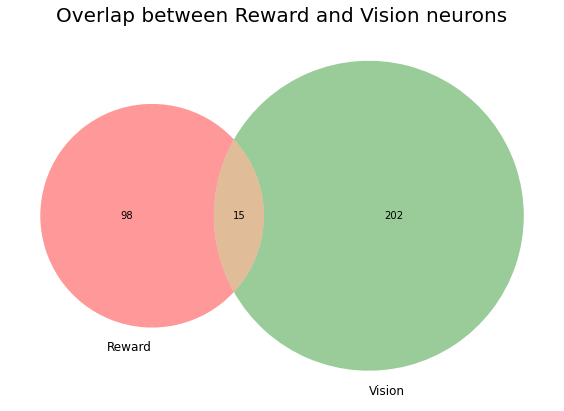

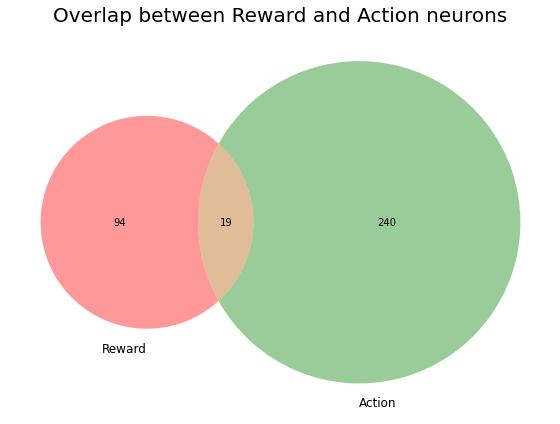

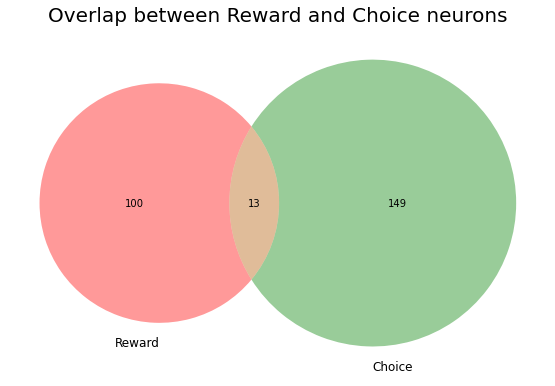

reward_area_all: ['SCm' 'DG' 'CA1' 'root' 'SCsg' 'MB' 'POL' 'VISp' 'GPe' 'VISrl' 'MRN'
 'POST' 'VISl']
reward_ratio: (6, 14)
neuron: (857, 342, 250)
reward_index: (86,)
reward_index ex.: [ 1 13 21 34 40]
vision_index: (172,)
action_index: (215,)
choice_index: (129,)
index_all: (4,)
r_v_and: (13,)
reward_ratio: [0.15116279 0.26744186 0.19767442 0.0755814  0.10697674 0.13178295]


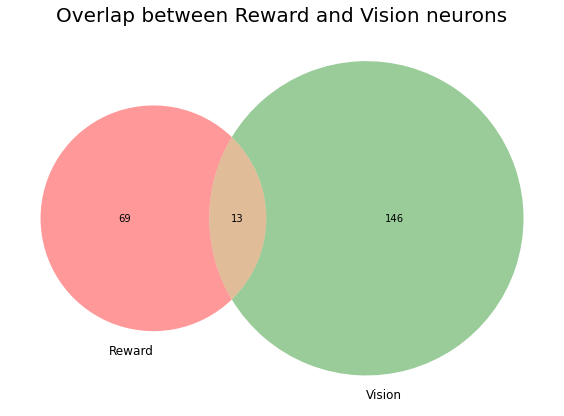

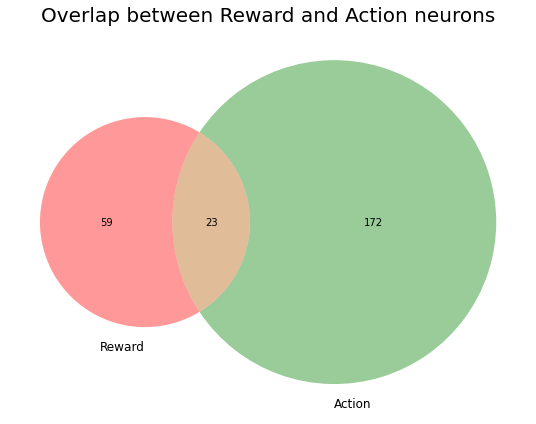

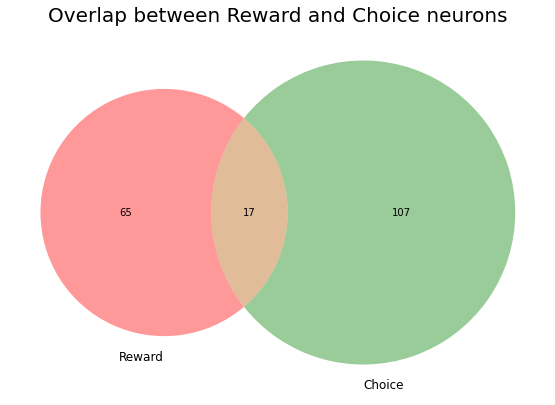

reward_area_all: ['PT' 'root' 'LSc' 'CP' 'MOp' 'LSr']
reward_ratio: (6, 7)
neuron: (698, 340, 250)
reward_index: (70,)
reward_index ex.: [ 6 10 19 21 33]
vision_index: (140,)
action_index: (175,)
choice_index: (105,)
index_all: (4,)
r_v_and: (10,)
reward_ratio: [0.14285714 0.17142857 0.14285714 0.07142857 0.06857143 0.0952381 ]


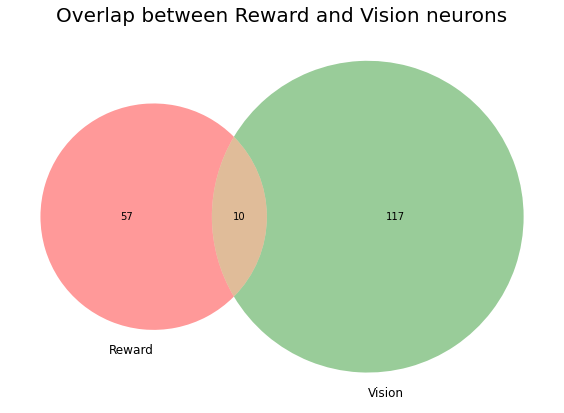

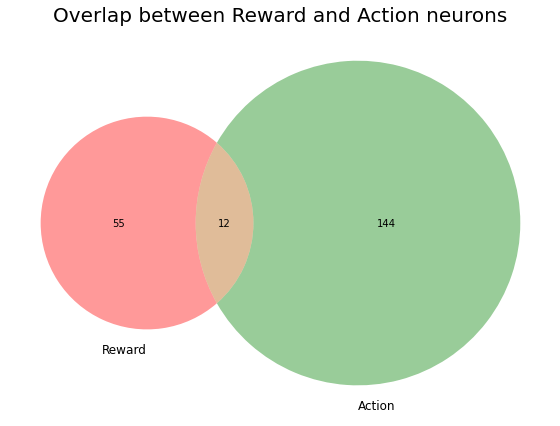

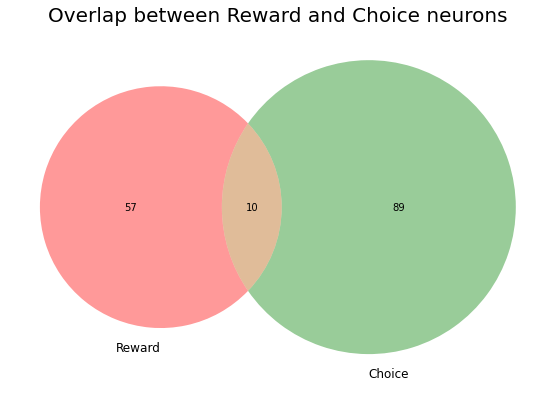

reward_area_all: ['DG' 'root' 'CA1' 'LGd' 'LH' 'SUB' 'VISp' 'MD' 'PL' 'VISam' 'ACA']
reward_ratio: (6, 12)
neuron: (983, 300, 250)
reward_index: (99,)
reward_index ex.: [20 23 25 32 48]
vision_index: (197,)
action_index: (246,)
choice_index: (148,)
index_all: (4,)
r_v_and: (18,)
reward_ratio: [0.18181818 0.15151515 0.14141414 0.09137056 0.06097561 0.09459459]


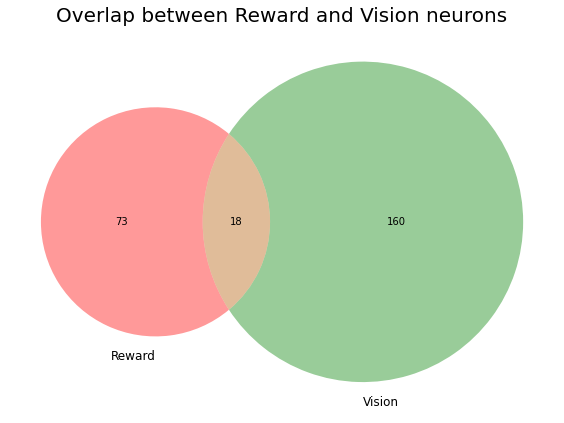

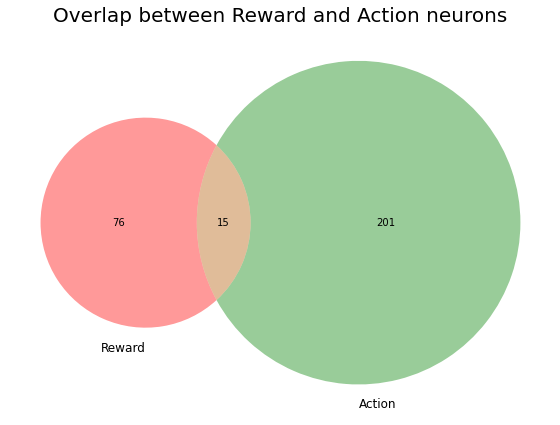

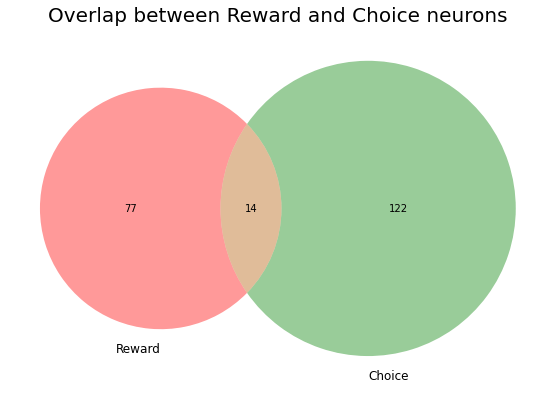

reward_area_all: ['SCm' 'SCs' 'MOs' 'DG' 'CA1' 'root' 'RN' 'MB' 'ACA' 'ZI' 'PL' 'MRN'
 'VISam' 'LGd']
reward_ratio: (6, 15)
neuron: (756, 268, 250)
reward_index: (76,)
reward_index ex.: [10 14 18 42 57]
vision_index: (152,)
action_index: (189,)
choice_index: (114,)
index_all: (4,)
r_v_and: (13,)
reward_ratio: [0.17105263 0.11842105 0.10526316 0.08552632 0.04761905 0.07017544]


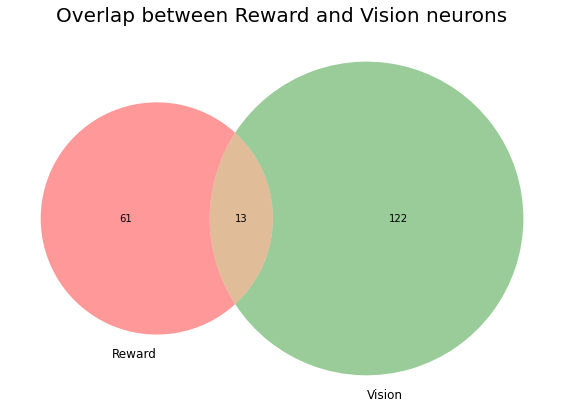

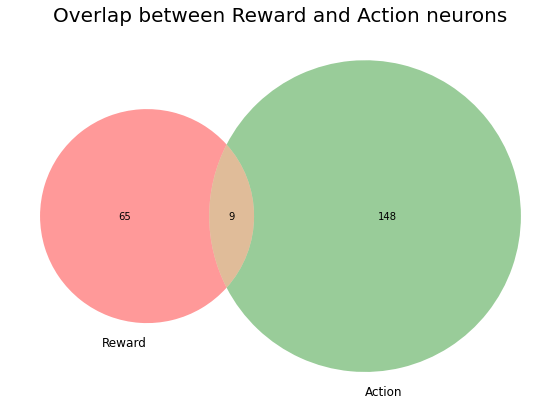

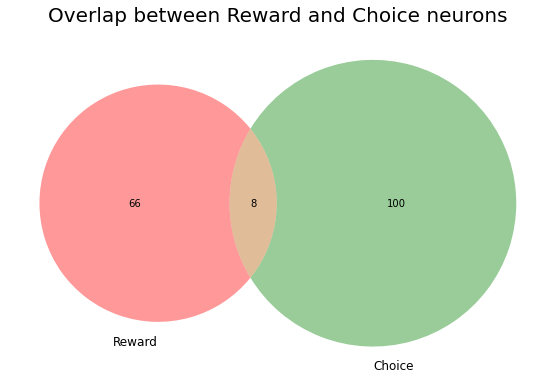

reward_area_all: ['SCm' 'SCs' 'MOs' 'CA1' 'ORB' 'RSP' 'VISp' 'MRN' 'PAG']
reward_ratio: (6, 10)
neuron: (743, 404, 250)
reward_index: (75,)
reward_index ex.: [ 3 16 19 26 27]
vision_index: (149,)
action_index: (186,)
choice_index: (112,)
index_all: (4,)
r_v_and: (10,)
reward_ratio: [0.13333333 0.21333333 0.14666667 0.06711409 0.08602151 0.09821429]


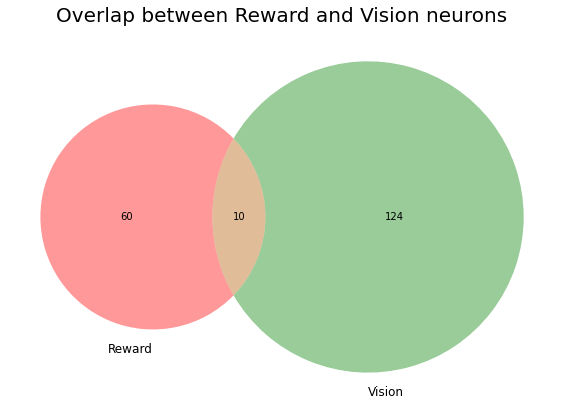

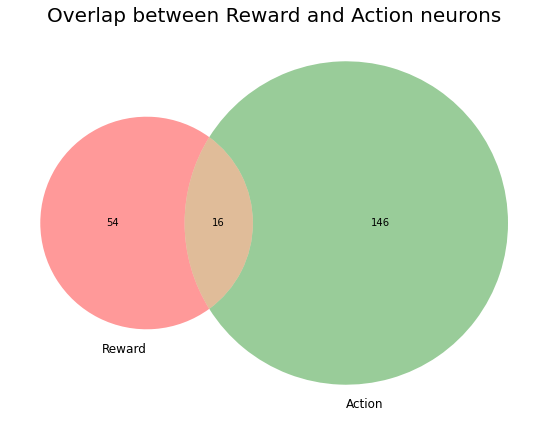

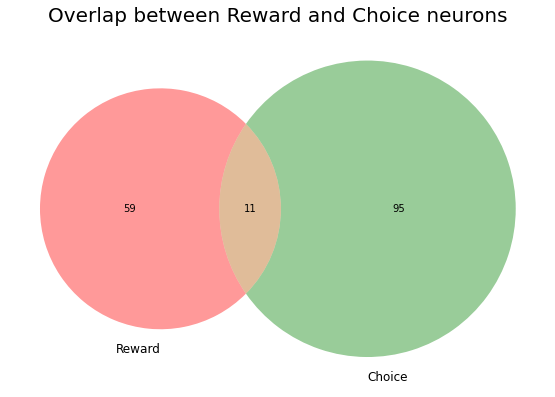

reward_area_all: ['root' 'BLA' 'MB' 'GPe' 'ZI' 'VPM' 'LGd']
reward_ratio: (6, 8)
neuron: (474, 280, 250)
reward_index: (48,)
reward_index ex.: [ 9 14 26 41 49]
vision_index: (95,)
action_index: (119,)
choice_index: (72,)
index_all: (4,)
r_v_and: (11,)
reward_ratio: [0.22916667 0.1875     0.1875     0.11578947 0.07563025 0.125     ]


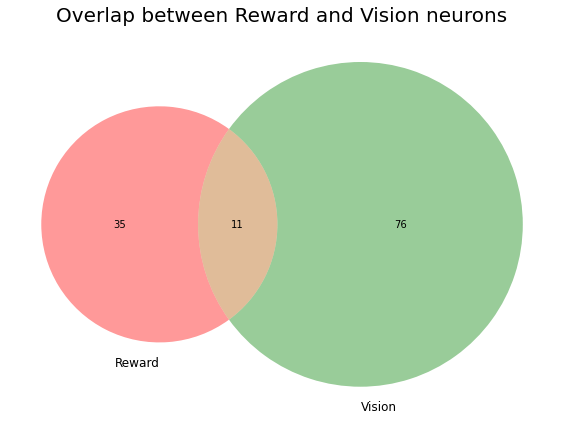

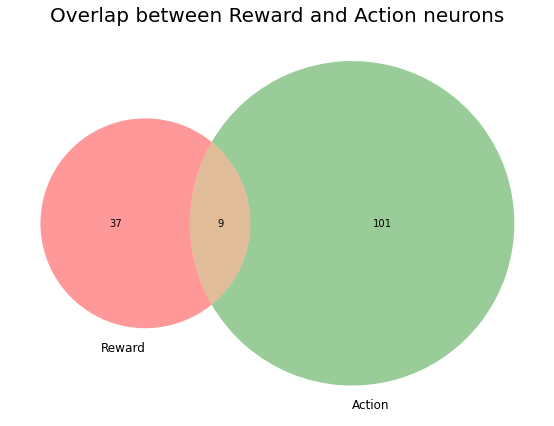

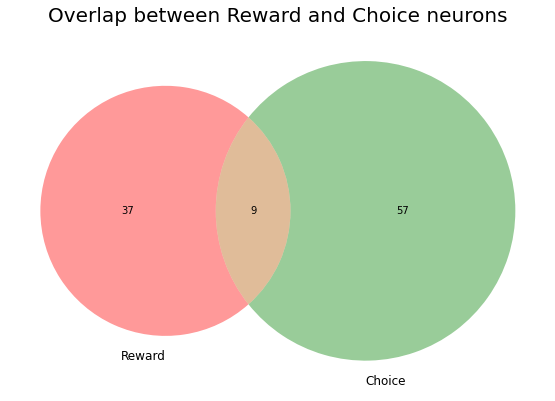

reward_area_all: ['SSp' 'TH' 'CA3' 'MB' 'SSs' 'LGd']
reward_ratio: (6, 7)
neuron: (565, 224, 250)
reward_index: (57,)
reward_index ex.: [36 51 63 68 69]
vision_index: (113,)
action_index: (142,)
choice_index: (85,)
index_all: (4,)
r_v_and: (7,)
reward_ratio: [0.12280702 0.26315789 0.15789474 0.0619469  0.1056338  0.10588235]


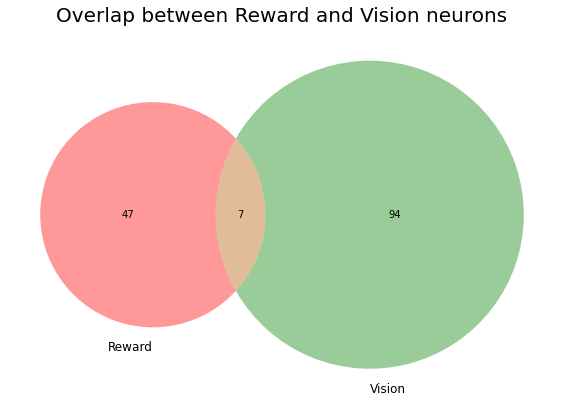

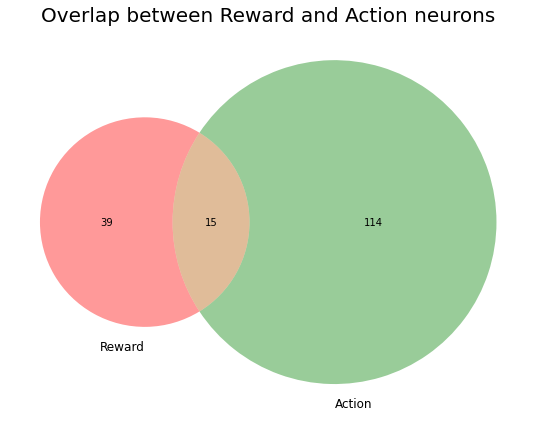

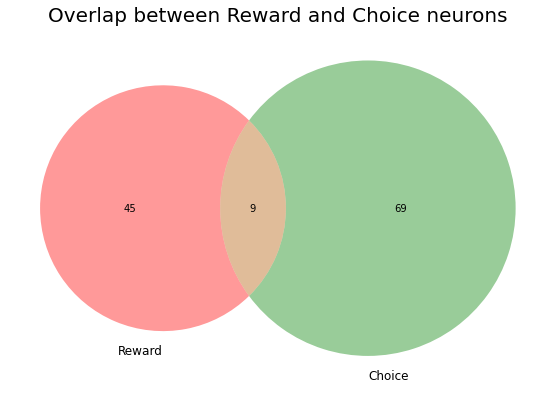

reward_area_all: ['RT' 'root' 'VPL' 'MEA' 'VPM']
reward_ratio: (6, 6)
neuron: (1089, 316, 250)
reward_index: (109,)
reward_index ex.: [ 4  4  7 26 33]
vision_index: (218,)
action_index: (273,)
choice_index: (164,)
index_all: (4,)
r_v_and: (17,)
reward_ratio: [0.1559633  0.19266055 0.11926606 0.07798165 0.07692308 0.07926829]


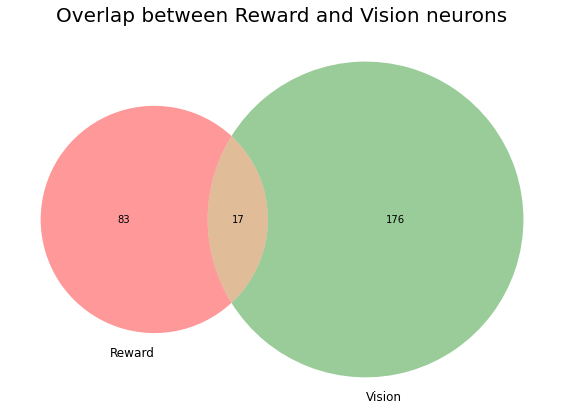

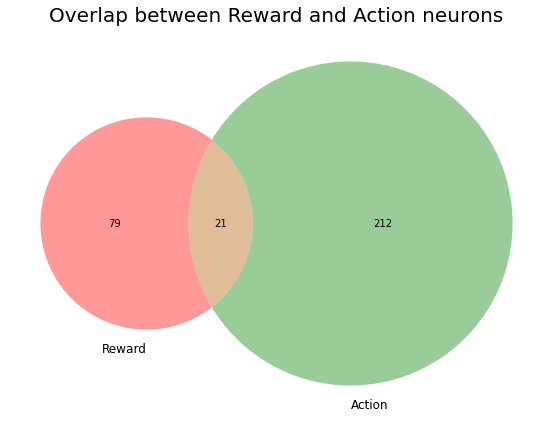

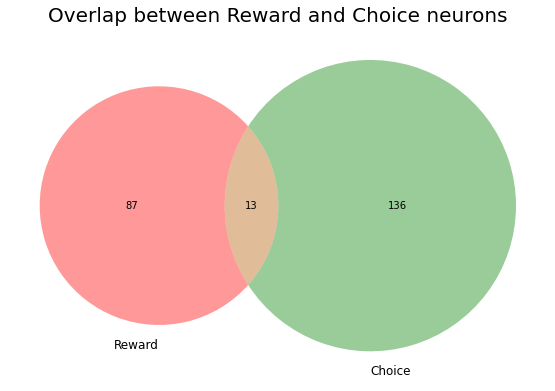

reward_area_all: ['root' 'CP' 'TH' 'SNr' 'CA3' 'ACB' 'SI' 'ZI' 'LGd']
reward_ratio: (6, 10)
neuron: (606, 247, 250)
reward_index: (61,)
reward_index ex.: [13 22 24 28 28]
vision_index: (122,)
action_index: (152,)
choice_index: (91,)
index_all: (4,)
r_v_and: (6,)
reward_ratio: [0.09836066 0.21311475 0.13114754 0.04918033 0.08552632 0.08791209]


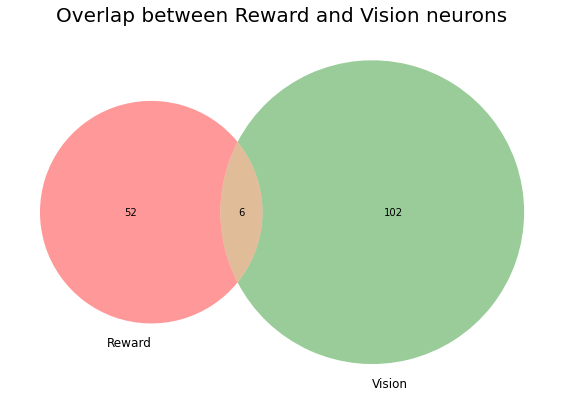

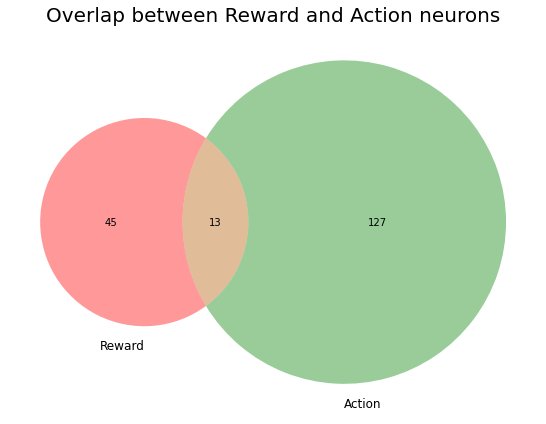

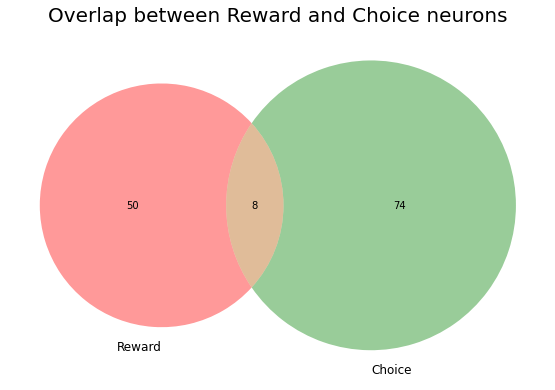

reward_area_all: ['DG' 'CA1' 'root' 'POL' 'SUB' 'VISpm' 'APN' 'VISam' 'LP']
reward_ratio: (6, 10)
neuron: (899, 235, 250)
reward_index: (90,)
reward_index ex.: [ 3  8 11 12 12]
vision_index: (180,)
action_index: (225,)
choice_index: (135,)
index_all: (4,)
r_v_and: (19,)
reward_ratio: [0.21111111 0.15555556 0.07777778 0.10555556 0.06222222 0.05185185]


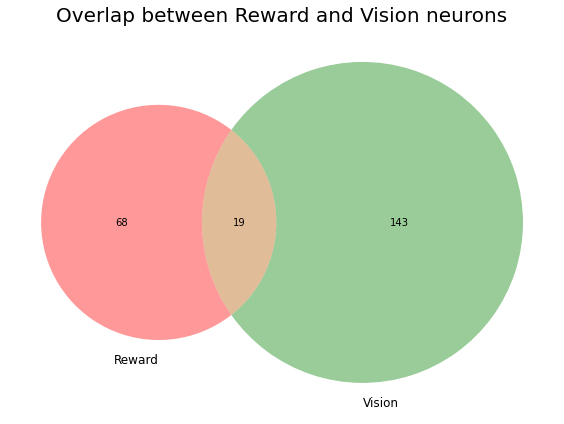

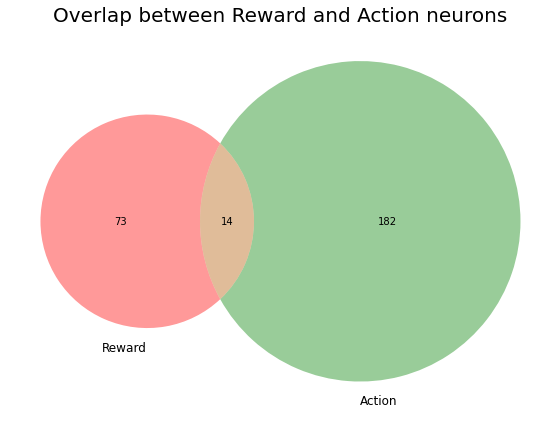

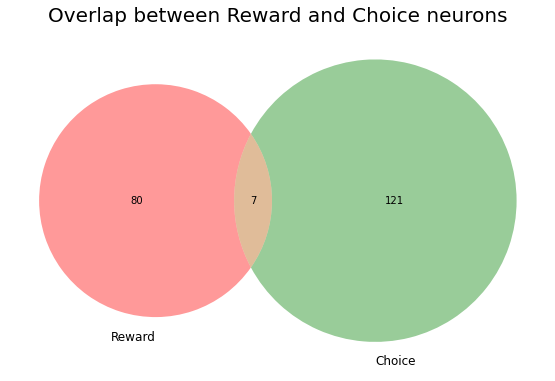

reward_area_all: ['LP' 'DG' 'TH' 'CA1' 'root' 'SPF' 'SUB' 'VISp' 'VISa' 'MG' 'LGd']
reward_ratio: (6, 12)
neuron: (578, 124, 250)
reward_index: (58,)
reward_index ex.: [ 6  8  9 17 27]
vision_index: (116,)
action_index: (145,)
choice_index: (87,)
index_all: (4,)
r_v_and: (8,)
reward_ratio: [0.13793103 0.27586207 0.10344828 0.06896552 0.11034483 0.06896552]


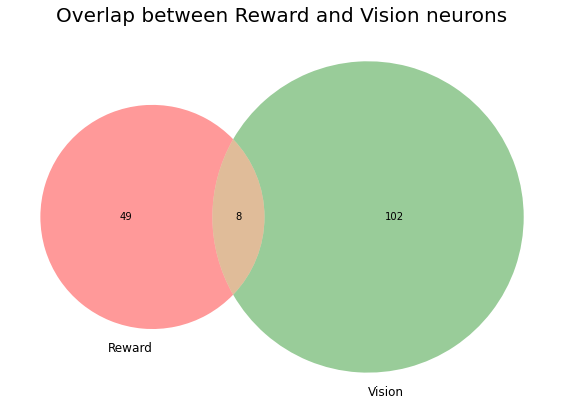

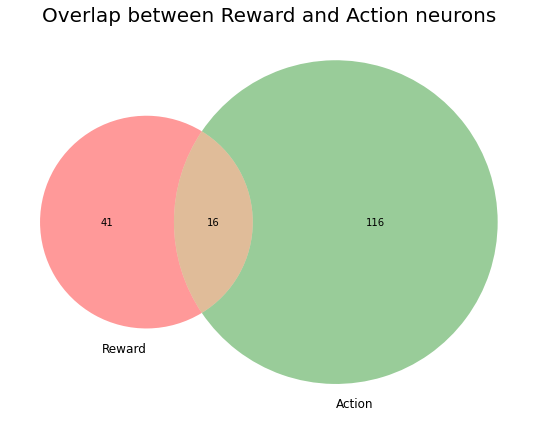

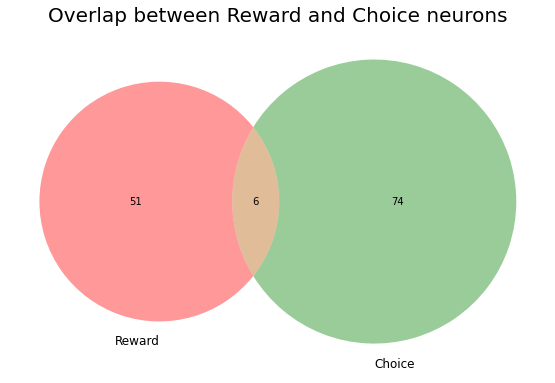

reward_area_all: ['SSp' 'root' 'VAL' 'LD' 'MOp']
reward_ratio: (6, 6)
neuron: (646, 444, 250)
reward_index: (65,)
reward_index ex.: [ 2  8  8 11 21]
vision_index: (130,)
action_index: (162,)
choice_index: (97,)
index_all: (4,)
r_v_and: (9,)
reward_ratio: [0.13846154 0.15384615 0.15384615 0.06923077 0.0617284  0.10309278]


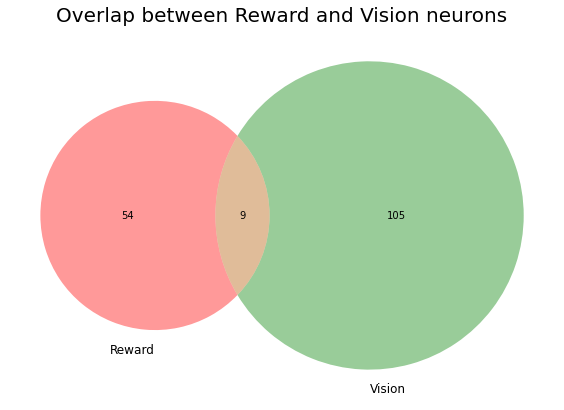

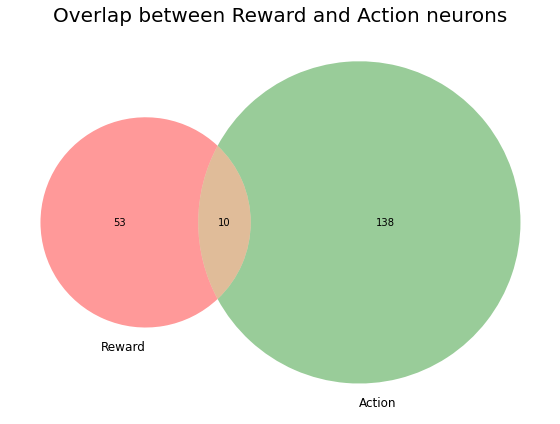

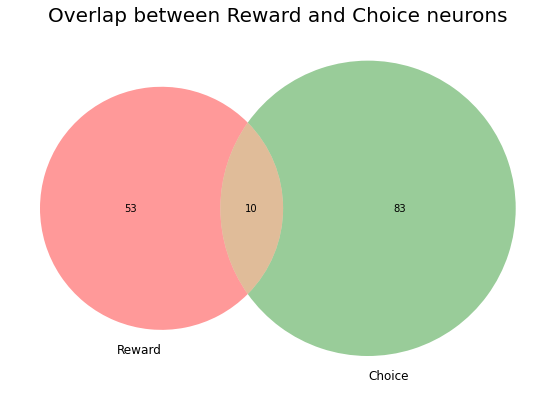

reward_area_all: ['MRN' 'MOs' 'TT' 'IC' 'RSP' 'SCsg' 'ACB' 'VISp' 'PL' 'ACA']
reward_ratio: (6, 11)
neuron: (1268, 151, 250)
reward_index: (127,)
reward_index ex.: [ 8  9 30 30 30]
vision_index: (254,)
action_index: (317,)
choice_index: (191,)
index_all: (4,)
r_v_and: (24,)
reward_ratio: [0.18897638 0.20472441 0.13385827 0.09448819 0.08201893 0.08900524]


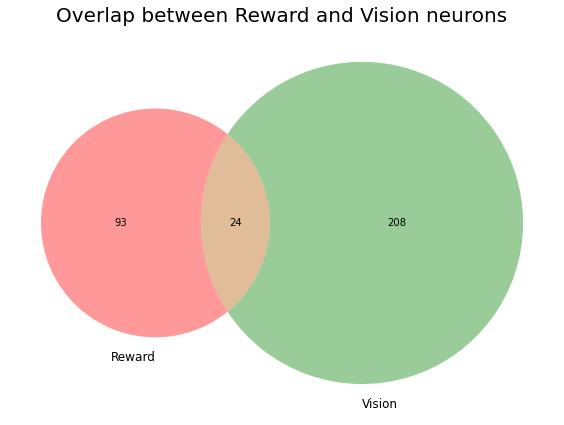

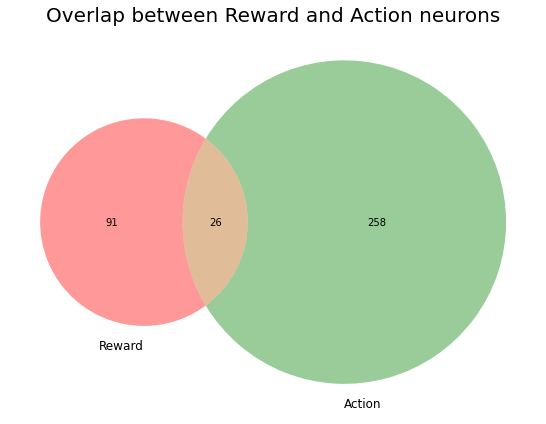

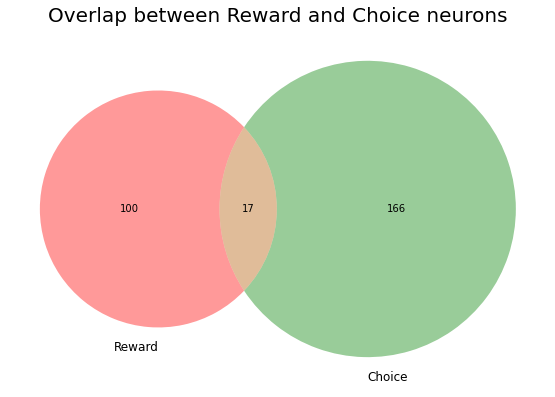

reward_area_all: ['DG' 'CA1' 'PO' 'root' 'VISam' 'LP']
reward_ratio: (6, 7)
neuron: (1337, 187, 250)
reward_index: (134,)
reward_index ex.: [ 3  6  7 13 18]
vision_index: (268,)
action_index: (335,)
choice_index: (201,)
index_all: (4,)
r_v_and: (19,)
reward_ratio: [0.14179104 0.19402985 0.1119403  0.07089552 0.07761194 0.07462687]


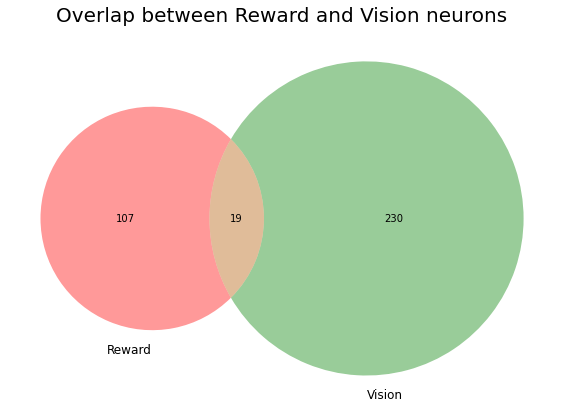

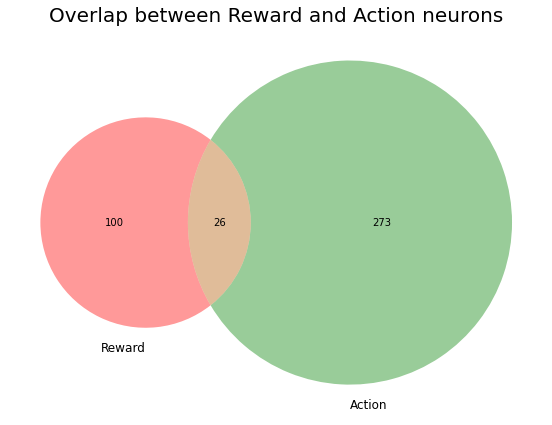

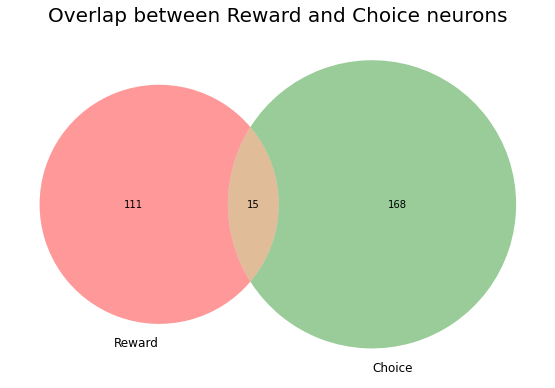

reward_area_all: ['MRN' 'root' 'CA1' 'SCig' 'RSP' 'SCsg' 'VISrl' 'VISpm' 'CA2']
reward_ratio: (6, 10)
neuron: (885, 261, 250)
reward_index: (89,)
reward_index ex.: [11 22 40 47 50]
vision_index: (177,)
action_index: (222,)
choice_index: (133,)
index_all: (4,)
r_v_and: (15,)
reward_ratio: [0.16853933 0.21348315 0.19101124 0.08474576 0.08558559 0.12781955]


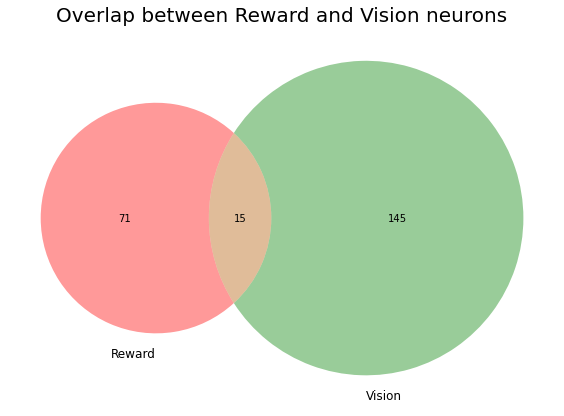

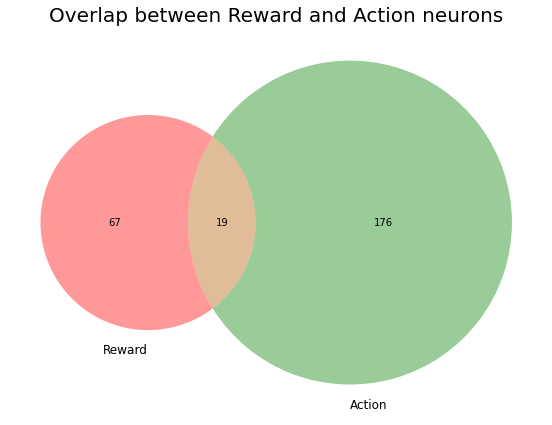

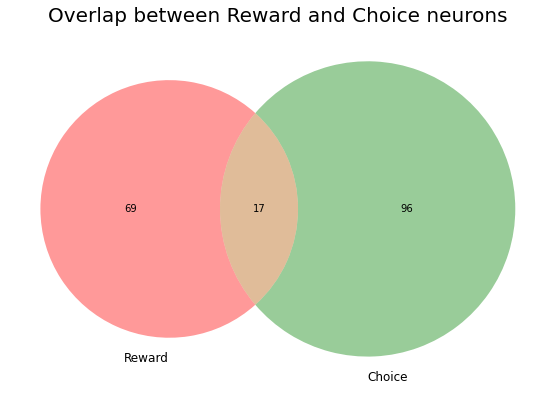

reward_area_all: ['MRN' 'MOs' 'TT' 'root' 'ILA' 'SCig' 'RSP' 'SCsg' 'DP' 'VISp' 'PL' 'ACA']
reward_ratio: (6, 13)
neuron: (1056, 178, 250)
reward_index: (106,)
reward_index ex.: [ 3  9 21 34 47]
vision_index: (212,)
action_index: (264,)
choice_index: (159,)
index_all: (4,)
r_v_and: (19,)
reward_ratio: [0.17924528 0.25471698 0.0754717  0.08962264 0.10227273 0.05031447]


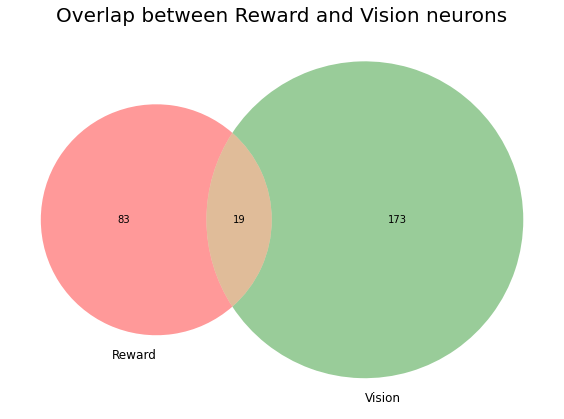

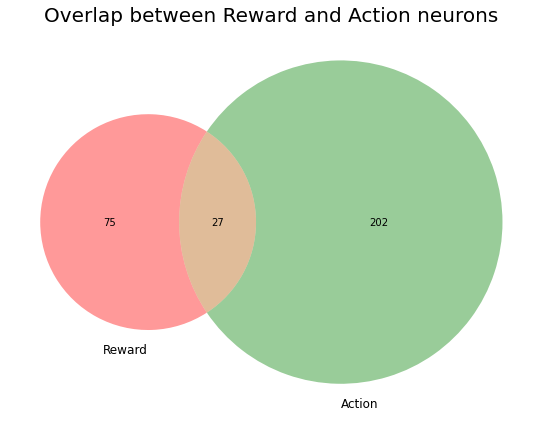

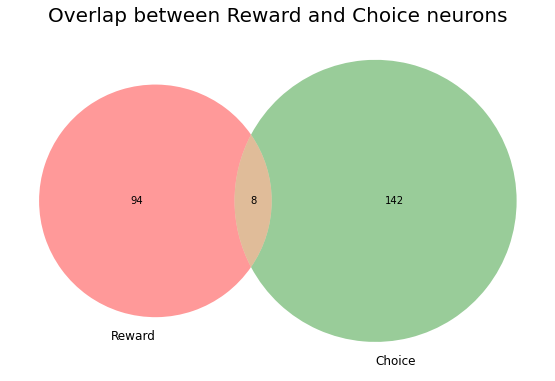

reward_area_all: ['MOs' 'SCig' 'root' 'VISp' 'MRN']
reward_ratio: (6, 6)
neuron: (563, 253, 250)
reward_index: (57,)
reward_index ex.: [ 2  2 35 42 44]
vision_index: (113,)
action_index: (141,)
choice_index: (85,)
index_all: (4,)
r_v_and: (10,)
reward_ratio: [0.1754386  0.22807018 0.21052632 0.08849558 0.09219858 0.14117647]


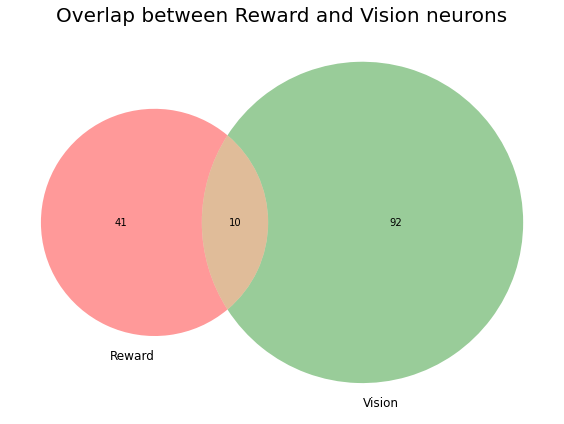

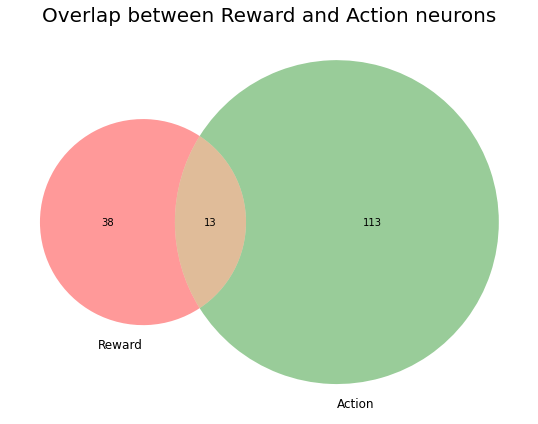

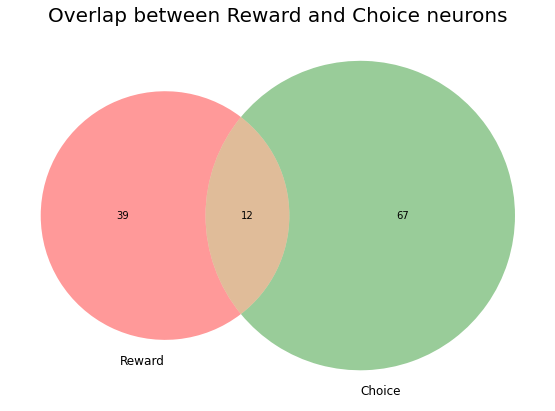

reward_area_all: ['MOs' 'PO' 'CA1' 'DG' 'ACB' 'LD' 'ACA' 'PL' 'VISam' 'LP']
reward_ratio: (6, 11)
neuron: (549, 142, 250)
reward_index: (55,)
reward_index ex.: [ 0  2  3  7 24]
vision_index: (110,)
action_index: (138,)
choice_index: (83,)
index_all: (4,)
r_v_and: (14,)
reward_ratio: [0.25454545 0.29090909 0.12727273 0.12727273 0.11594203 0.08433735]


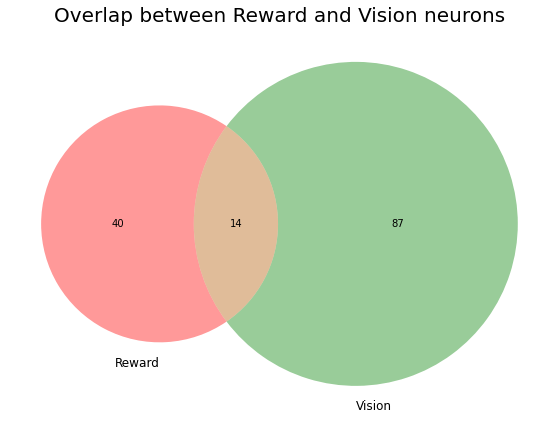

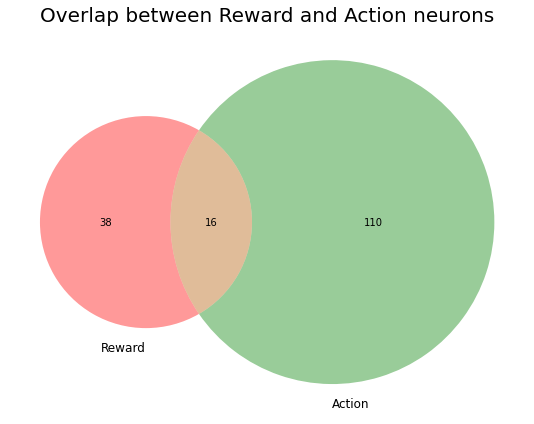

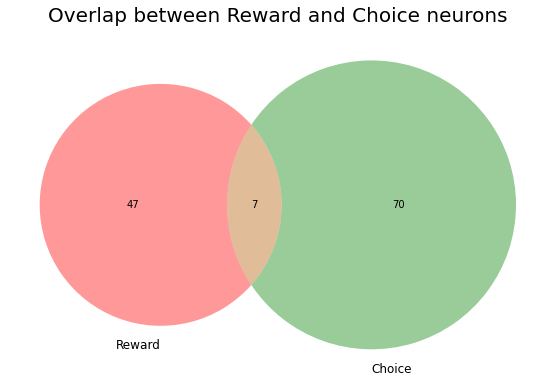

reward_area_all: ['SCig' 'CA1' 'DG' 'root' 'RSP' 'SCsg' 'POL' 'MRN' 'VISpm' 'APN' 'LP']
reward_ratio: (6, 12)
neuron: (750, 128, 250)
reward_index: (75,)
reward_index ex.: [ 4 12 13 25 27]
vision_index: (150,)
action_index: (188,)
choice_index: (113,)
index_all: (4,)
r_v_and: (17,)
reward_ratio: [0.22666667 0.28       0.06666667 0.11333333 0.11170213 0.04424779]


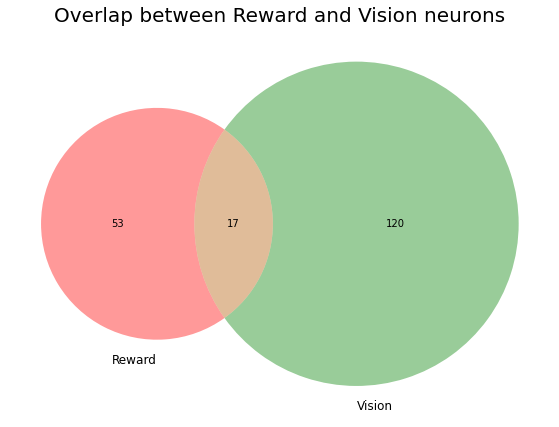

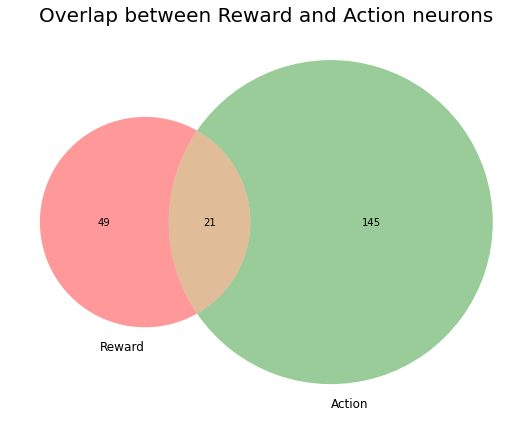

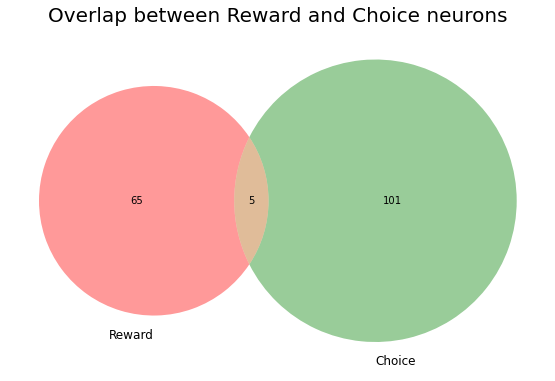

reward_area_all: ['CP' 'MOp' 'SSp']
reward_ratio: (6, 4)
neuron: (942, 143, 250)
reward_index: (95,)
reward_index ex.: [ 3 11 19 23 44]
vision_index: (189,)
action_index: (236,)
choice_index: (142,)
index_all: (4,)
r_v_and: (24,)
reward_ratio: [0.25263158 0.23157895 0.17894737 0.12698413 0.09322034 0.11971831]


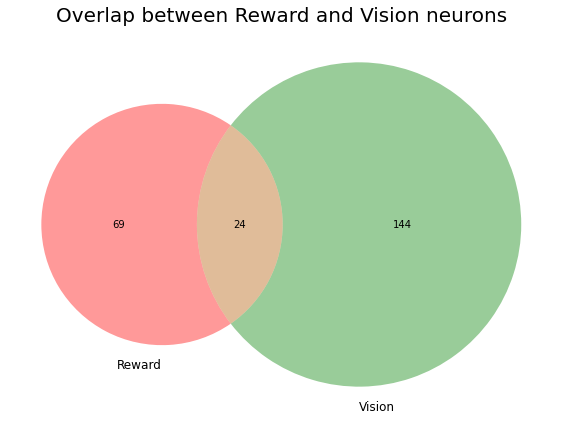

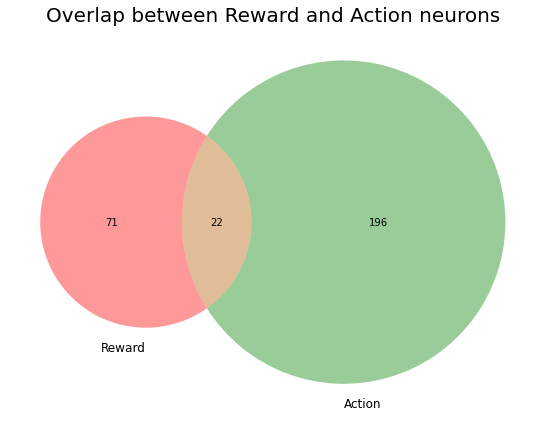

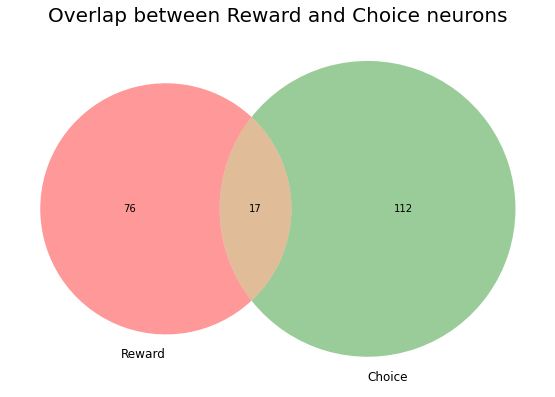

reward_area_all: ['MOs' 'LS' 'PO' 'DG' 'CA1' 'root' 'RSP' 'SUB' 'ACA' 'CL' 'MD' 'VISa'
 'VPM' 'LP']
reward_ratio: (6, 15)
neuron: (977, 237, 250)
reward_index: (98,)
reward_index ex.: [ 6 17 20 27 33]
vision_index: (196,)
action_index: (245,)
choice_index: (147,)
index_all: (4,)
r_v_and: (22,)
reward_ratio: [0.2244898  0.19387755 0.17346939 0.1122449  0.07755102 0.11564626]


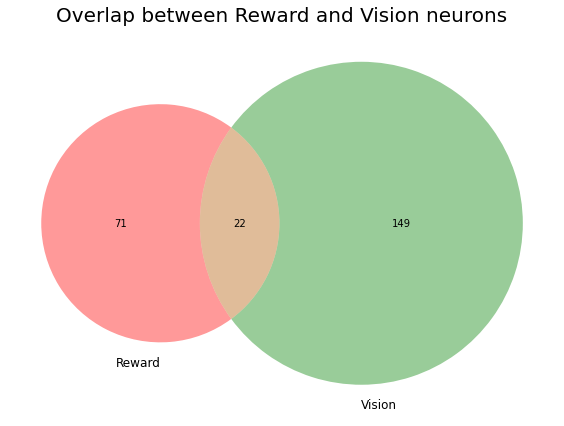

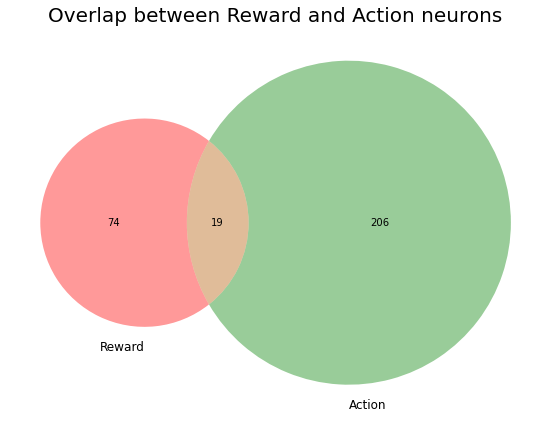

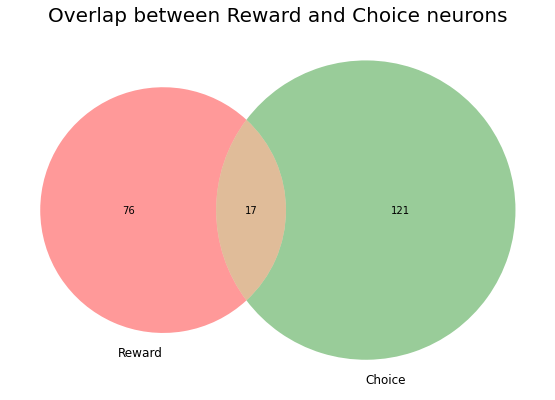

reward_area_all: ['SCm' 'MOs' 'SNr' 'TH' 'ORB' 'OLF' 'CA3' 'POST']
reward_ratio: (6, 9)
neuron: (522, 260, 250)
reward_index: (53,)
reward_index ex.: [ 5  6  6 12 13]
vision_index: (105,)
action_index: (131,)
choice_index: (79,)
index_all: (4,)
r_v_and: (10,)
reward_ratio: [0.18867925 0.20754717 0.13207547 0.0952381  0.08396947 0.08860759]


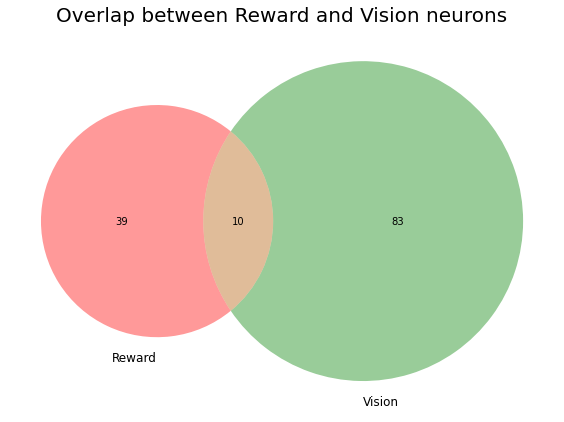

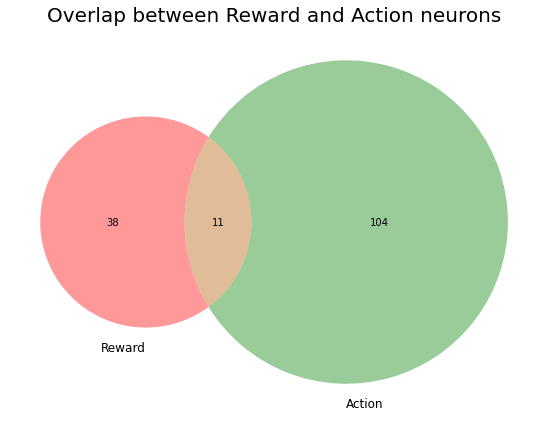

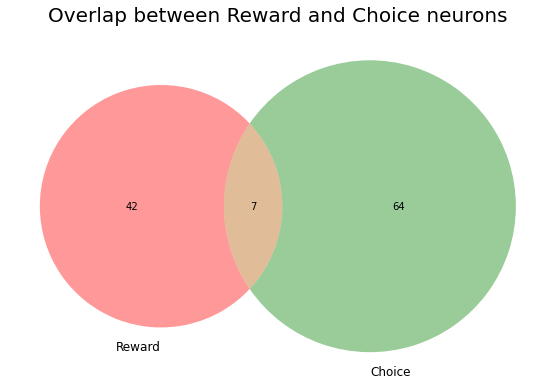

reward_area_all: ['SCm' 'SCs' 'MOs' 'root' 'ORB' 'RSP' 'MRN' 'PAG']
reward_ratio: (6, 9)
neuron: (613, 191, 250)
reward_index: (62,)
reward_index ex.: [ 6 18 20 41 57]
vision_index: (123,)
action_index: (154,)
choice_index: (92,)
index_all: (4,)
r_v_and: (9,)
reward_ratio: [0.14516129 0.20967742 0.11290323 0.07317073 0.08441558 0.07608696]


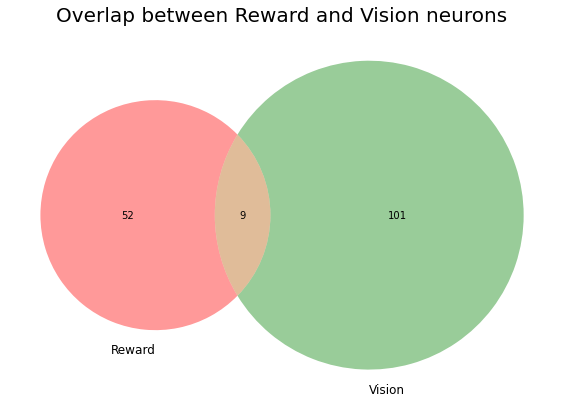

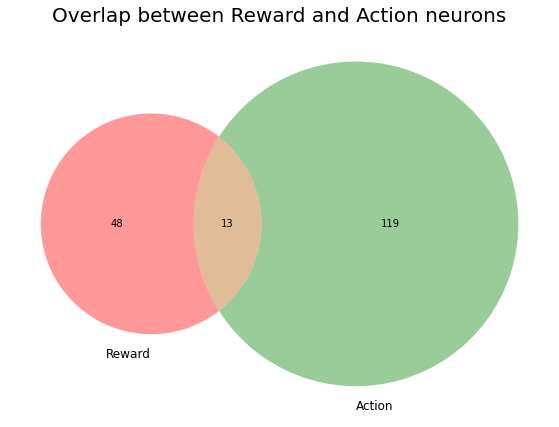

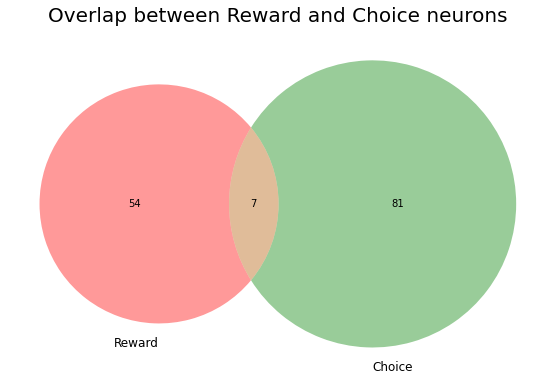

reward_area_all: ['EP' 'SNr' 'CP' 'CA1' 'ZI' 'VPM' 'LGd']
reward_ratio: (6, 8)
neuron: (781, 296, 250)
reward_index: (79,)
reward_index ex.: [ 7 12 25 56 57]
vision_index: (157,)
action_index: (196,)
choice_index: (118,)
index_all: (4,)
r_v_and: (13,)
reward_ratio: [0.16455696 0.17721519 0.16455696 0.08280255 0.07142857 0.11016949]


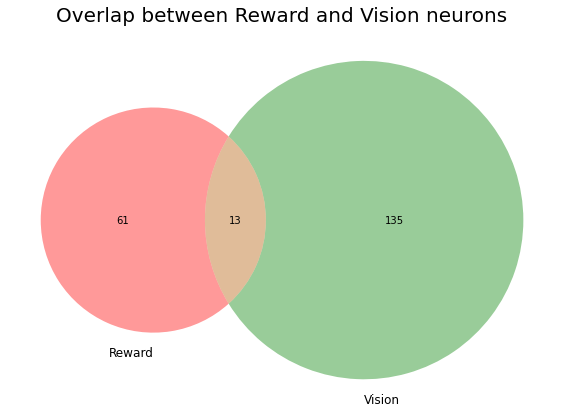

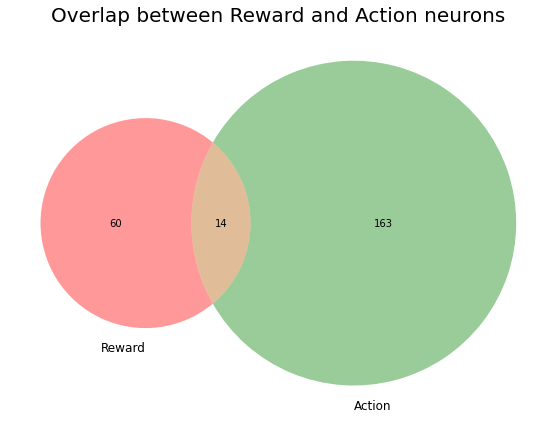

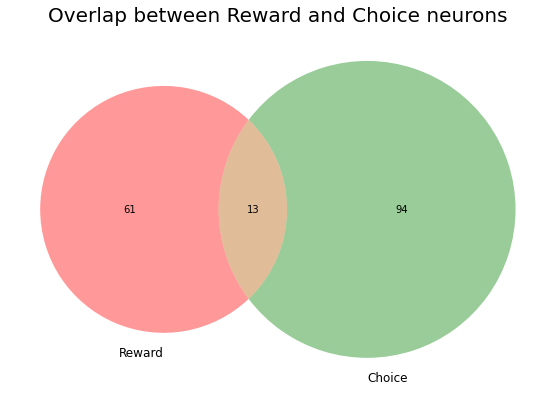

reward_area_all: ['RT' 'root' 'COA' 'PO' 'MB' 'BMA' 'LP']
reward_ratio: (6, 8)
neuron: (795, 311, 250)
reward_index: (80,)
reward_index ex.: [ 7 23 51 57 68]
vision_index: (159,)
action_index: (199,)
choice_index: (120,)
index_all: (4,)
r_v_and: (17,)
reward_ratio: [0.2125     0.2125     0.1375     0.10691824 0.08542714 0.09166667]


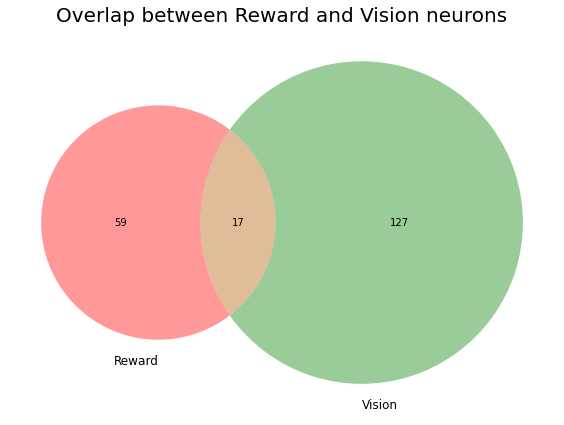

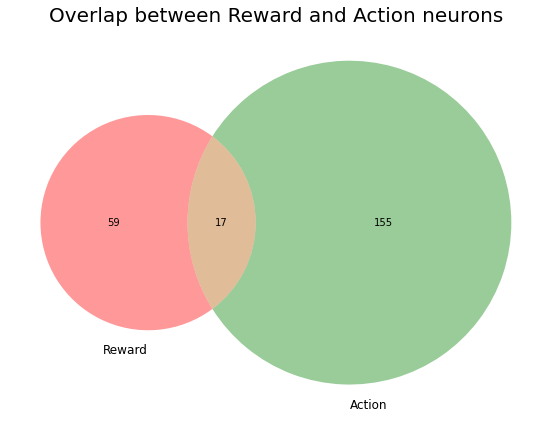

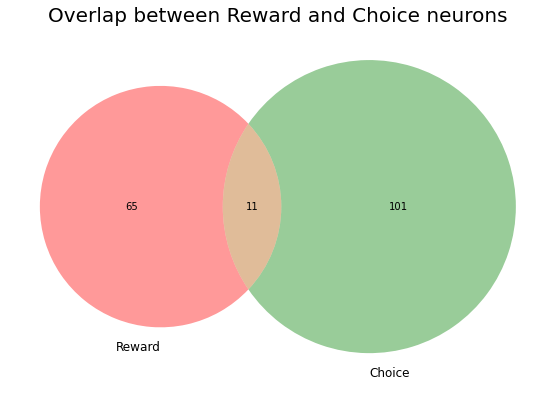

reward_area_all: ['MOs' 'LS' 'DG' 'TH' 'CA1' 'RSP' 'ACA' 'MD' 'LP' 'VISam' 'LGd']
reward_ratio: (6, 12)
neuron: (680, 258, 250)
reward_index: (68,)
reward_index ex.: [23 32 74 77 80]
vision_index: (136,)
action_index: (170,)
choice_index: (102,)
index_all: (4,)
r_v_and: (13,)
reward_ratio: [0.19117647 0.29411765 0.14705882 0.09558824 0.11764706 0.09803922]


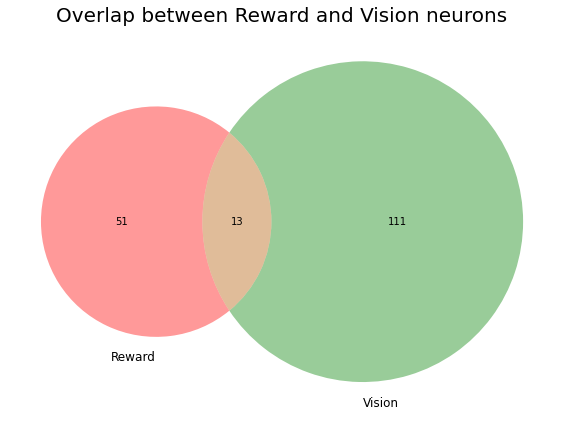

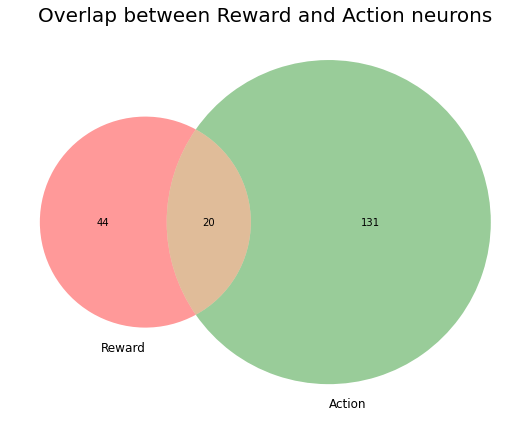

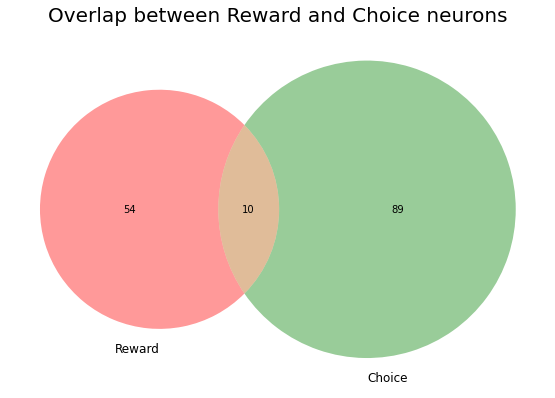

reward_area_all: ['SCm' 'MOs' 'root' 'SCsg' 'PL' 'MRN' 'CA' 'VISam']
reward_ratio: (6, 9)
neuron: (1055, 181, 250)
reward_index: (106,)
reward_index ex.: [ 4  5  6  7 38]
vision_index: (211,)
action_index: (264,)
choice_index: (159,)
index_all: (4,)
r_v_and: (20,)
reward_ratio: [0.18867925 0.23584906 0.16037736 0.09478673 0.09469697 0.10691824]


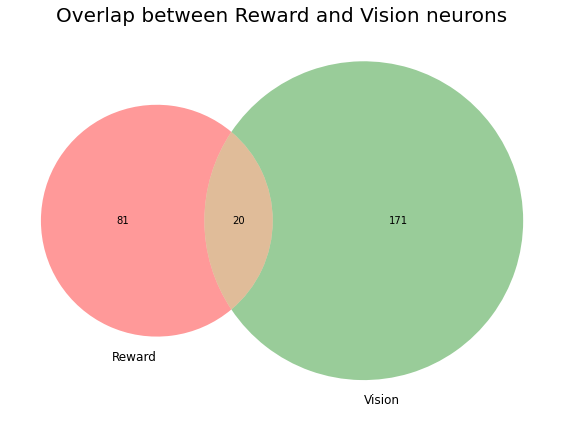

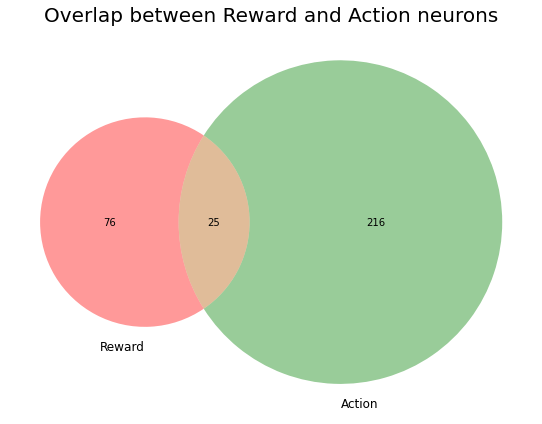

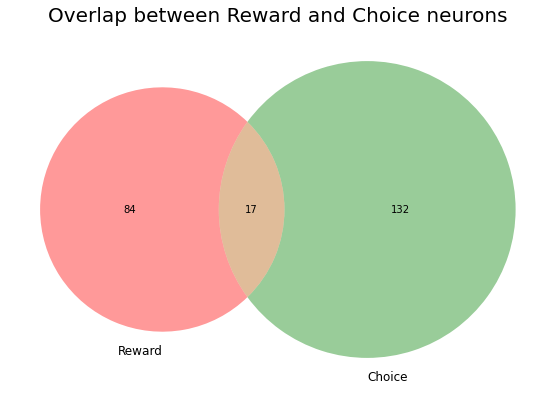

reward_area_all: ['SCm' 'MOs' 'root' 'ORB' 'RSP' 'MB' 'PAG' 'VISam']
reward_ratio: (6, 9)
neuron: (805, 199, 250)
reward_index: (81,)
reward_index ex.: [ 5  6 18 28 51]
vision_index: (161,)
action_index: (202,)
choice_index: (121,)
index_all: (4,)
r_v_and: (15,)
reward_ratio: [0.18518519 0.22222222 0.13580247 0.0931677  0.08910891 0.09090909]


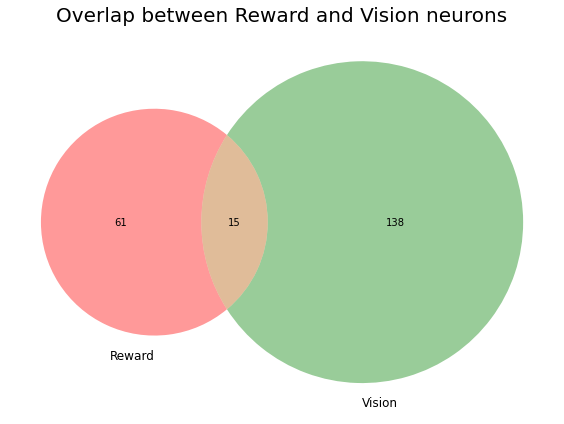

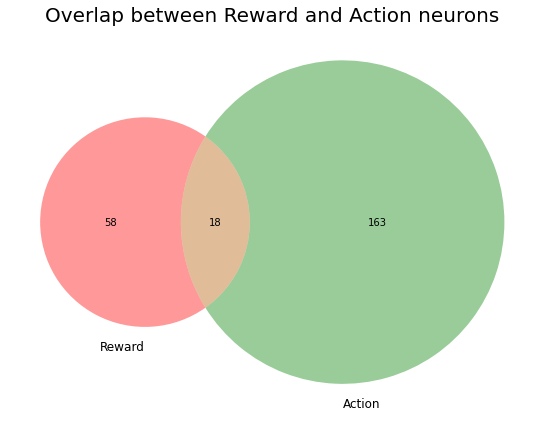

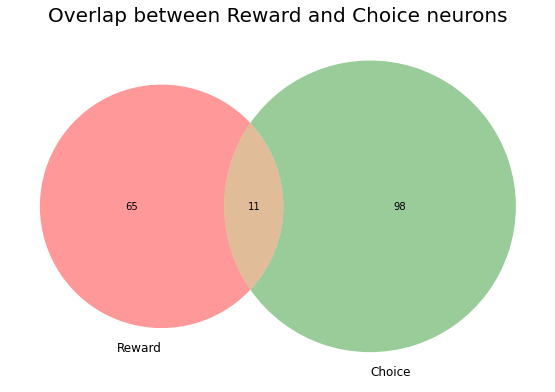

reward_area_all: ['SNr' 'root' 'BLA' 'CA3' 'GPe' 'LGd']
reward_ratio: (6, 7)
neuron: (1348, 343, 250)
reward_index: (135,)
reward_index ex.: [14 25 33 36 48]
vision_index: (270,)
action_index: (337,)
choice_index: (203,)
index_all: (4,)
r_v_and: (33,)
reward_ratio: [0.24444444 0.23703704 0.11111111 0.12222222 0.09495549 0.07389163]


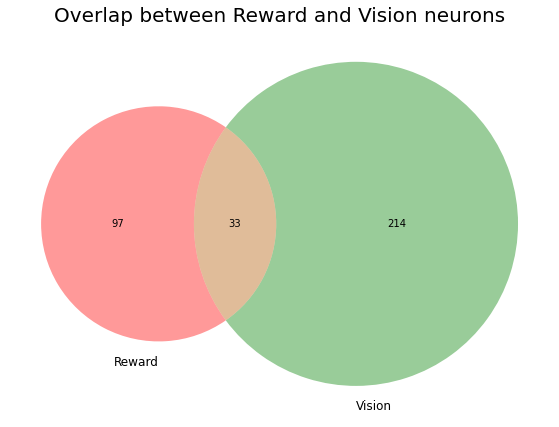

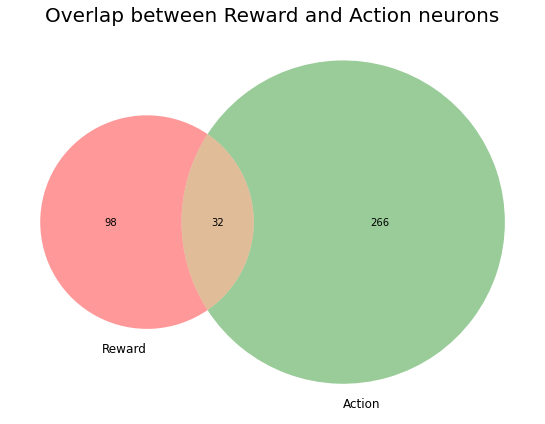

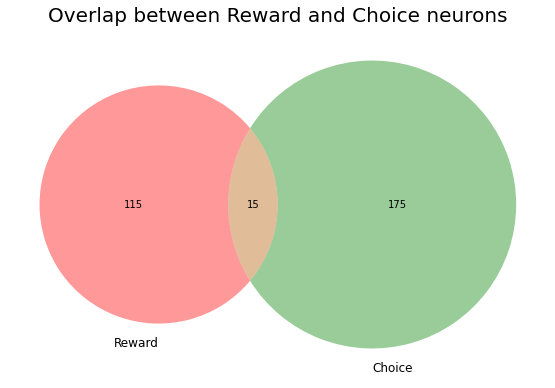

reward_area_all: ['MOs' 'root' 'CA1' 'DG' 'ILA' 'SUB' 'ACA' 'PL' 'VISam' 'LP']
reward_ratio: (6, 11)


In [14]:
## ここでは仮に、全個体において〇〇-related neuronは全体の△%というインデックスが取得できたと仮定して進めていく

# reward: 10%, vision: 20%, action: 25%, choice: 15%
# 各neuronのインデックスが取得できたらここは不要
reward_rate = 0.1
vision_rate = 0.2
action_rate = 0.25
choice_rate = 0.15

# 〇〇-related neuronのindexの取り出し
for animal_num in range(39):

  reward_index = np.sort(np.random.randint(0,len(alldata[animal_num]['spks']),(int(np.ceil(len(alldata[animal_num]['spks']) * reward_rate),))))
  vision_index = np.sort(np.random.randint(0,len(alldata[animal_num]['spks']),(int(np.ceil(len(alldata[animal_num]['spks']) * vision_rate),))))
  action_index = np.sort(np.random.randint(0,len(alldata[animal_num]['spks']),(int(np.ceil(len(alldata[animal_num]['spks']) * action_rate),))))
  choice_index = np.sort(np.random.randint(0,len(alldata[animal_num]['spks']),(int(np.ceil(len(alldata[animal_num]['spks']) * choice_rate),))))

  index_all = np.array([reward_index, vision_index, action_index, choice_index])

  print('neuron: {}'.format(alldata[animal_num]['spks'].shape)) # 各ニューロン、トライアル、時間ごとのスパイク数︎（0個体目であれば最大6）が入っている。1次元目はneuron数、2次元目はtrial数（visual stimulationの数）、3次元目は時間（視覚刺激提示開始前0.5秒前から2秒後まで）
  print('reward_index: {}'.format(reward_index.shape)) 
  print('reward_index ex.: {}'.format(reward_index[0:5])) 
  print('vision_index: {}'.format(vision_index.shape)) 
  print('action_index: {}'.format(action_index.shape)) 
  print('choice_index: {}'.format(choice_index.shape)) 

  print('index_all: {}'.format(index_all.shape)) 

  # ここまででindexを抽出できた

  ## それぞれがどの程度オーバーラップしているかの計算
  # まずは全領域で
  # ベン図のイメージ
  # 単純に各インデックスのオーバーラップを%で計算

  # まずは各インデックスのうち共通部分の抽出

  # ex. r_v_andはreward_indexとvision_indexの共通部分
  r_v_and = np.intersect1d(reward_index, vision_index)
  r_a_and = np.intersect1d(reward_index, action_index)
  r_c_and = np.intersect1d(reward_index, choice_index)
  v_a_and = np.intersect1d(vision_index, action_index)
  v_c_and = np.intersect1d(vision_index, choice_index)
  a_c_and = np.intersect1d(action_index, choice_index)

  print('r_v_and: {}'.format(r_v_and.shape)) 

  and_all = np.array([r_v_and, r_a_and, r_c_and, v_a_and, v_c_and, a_c_and])

  # reward neuronのうち、vision/action/choiceにも関わるニューロンの割合
  reward_ratio = []
  for i in range(3):
    reward_vac_ratio = len(and_all[i])/len(reward_index)
    reward_ratio = np.append(reward_ratio, reward_vac_ratio)

  # vision/action/choice neuronのうち、rewardにも関わるニューロンの割合
  for i in range(3):
    vac_reward_ratio = len(and_all[i])/len(index_all[i+1])
    reward_ratio = np.append(reward_ratio, vac_reward_ratio)

  # reward_ratioは、最初3つが「reward neuronのうち、vision/action/choice neuronでもあるneuronの割合」
  # 後3つが「vision/action/choice neuronのうち、reward neuronでもあるneuronの割合」
  print('reward_ratio: {}'.format(reward_ratio)) 

  # これをベン図でplot

  # これをベン図でplot

  plt.figure(figsize=(8,6))
  venn2(subsets=[set(reward_index),set(vision_index)],set_labels=('Reward','Vision'))
  plt.title('Overlap between Reward and Vision neurons',fontsize=20)
  plt.show()

  plt.figure(figsize=(8,6))
  venn2(subsets=[set(reward_index),set(action_index)],set_labels=('Reward','Action'))
  plt.title('Overlap between Reward and Action neurons',fontsize=20)
  plt.show()

  plt.figure(figsize=(8,6))
  venn2(subsets=[set(reward_index),set(choice_index)],set_labels=('Reward','Choice'))
  plt.title('Overlap between Reward and Choice neurons',fontsize=20)
  plt.show()

  ## 次に各領域ごとのreward neuronの割合を論文fig.3d,eのようにplotしたい

  # ・・・・・・・・・・・・・・・・・・・・・・・

  ## 次に各領域ごとにreward_ratioを計算したい
  # reward_indexを領域ごとに分類
  # reward neuronが含まれている領域を抽出
  reward_area = alldata[animal_num]['brain_area'][reward_index]
  reward_area_all = np.array(list(set(reward_area)))
  print('reward_area_all: {}'.format(reward_area_all)) 

  # 同じことをvision/action/choice neuronに対しても行う
  vision_area = alldata[animal_num]['brain_area'][vision_index]
  vision_area_all = np.array(list(set(vision_area)))
  action_area = alldata[animal_num]['brain_area'][action_index]
  action_area_all = np.array(list(set(action_area)))
  choice_area = alldata[animal_num]['brain_area'][choice_index]
  choice_area_all = np.array(list(set(choice_area)))

  # reward_indexをreward_areaごとに分類
  reward_ratio_area = []
  for i in range(len(reward_area_all)):
    reward_ratio_each_area = []
    # 各reward領域における各〇〇-related neuronのindexを抽出
    # reward_index_each_areaは、reward_indexのうち△△領域のindex
    reward_index_each_area = np.where(reward_area == reward_area_all[i])
    # vision/action/choice_index_each_areaは、reward neuronの△△領域に存在するvision/action/choice neuronのindex
    vision_index_each_area = np.where(vision_area == reward_area_all[i])
    action_index_each_area = np.where(action_area == reward_area_all[i])
    choice_index_each_area = np.where(choice_area == reward_area_all[i])

    index_all_each_area = np.array([reward_index_each_area, vision_index_each_area, action_index_each_area, choice_index_each_area])

    # その領域における共通部分を計算
    # ex. r_v_andはreward_indexとvision_indexの共通部分
    r_v_and = np.intersect1d(reward_index_each_area, vision_index_each_area)
    r_a_and = np.intersect1d(reward_index_each_area, action_index_each_area)
    r_c_and = np.intersect1d(reward_index_each_area, choice_index_each_area)
    v_a_and = np.intersect1d(vision_index_each_area, action_index_each_area)
    v_c_and = np.intersect1d(vision_index_each_area, choice_index_each_area)
    a_c_and = np.intersect1d(action_index_each_area, choice_index_each_area)

    and_all = np.array([r_v_and, r_a_and, r_c_and, v_a_and, v_c_and, a_c_and])

      # vision/action/choice_index_each_areaが空集合だと133行目で分母0のエラーが出てしまうので、(np.array([0]),)で置き換えている
    # reward_index_each_eraは空集合でも128行目には影響がないのでそのまま
    if len(vision_index_each_area[0])==0:
      vision_index_each_area = (np.array([0]),)
    if len(action_index_each_area[0])==0:
      action_index_each_area = (np.array([0]),)
    if len(choice_index_each_area[0])==0:
      choice_index_each_area = (np.array([0]),)
    
    index_all_each_area = np.array([reward_index_each_area, vision_index_each_area, action_index_each_area, choice_index_each_area])
    #print('index_all_each_area: {}'.format(index_all_each_area)) 

    # 各領域ごとのreward_ratioを計算
    # reward neuronのうち、vision/action/choiceにも関わるニューロンの割合
    reward_ratio_each_area = []
    for j in range(3):
      reward_vac_ratio = len(and_all[j])/len(reward_index_each_area[0])
      reward_ratio_each_area = np.append(reward_ratio_each_area, reward_vac_ratio)

    # vision/action/choice neuronのうち、rewardにも関わるニューロンの割合
    for k in range(3):
      vac_reward_ratio = len(and_all[k])/len(index_all_each_area[k+1][0])
      reward_ratio_each_area = np.append(reward_ratio_each_area, vac_reward_ratio)

    # reward_ratio_each_areaは(6,)のベクトル、最初3つが「各reward領域におけるreward neuronのうち、vision/action/choice neuronでもあるneuronの割合」
    # 後3つが「各reward領域におけるvision/action/choice neuronのうち、reward neuronでもあるneuronの割合」
    # これを全領域で結合する
    reward_ratio_area = np.hstack((reward_ratio_area, reward_ratio_each_area))
    
  # reward_ratioは(6, reward領域数+1)のベクトル、1次元目の最初3つが「各reward領域におけるreward neuronのうち、vision/action/choice neuronでもあるneuronの割合」
  # 後3つが「各reward領域におけるvision/action/choice neuronのうち、reward neuronでもあるneuronの割合」
  # 2次元目は最初が全領域をまとめて計算した場合、2つ目以降が各reward領域。順番はreward_area_allの順
  reward_ratio = np.hstack((reward_ratio, reward_ratio_area))
  reward_ratio = reward_ratio.reshape(6, len(reward_area_all)+1)
  print('reward_ratio: {}'.format(reward_ratio.shape)) 

  # ここまでで、全領域&各領域ごとにreward neuronがvision/action/choice neuronとどの程度オーバーラップしているかを計算できた

# 最後に、これを全個体で1つのデータにしたい（が、サイズの違う行列をどうまとめるかが分からない）